In [43]:
import openai

client = openai.OpenAI(
    api_key =  myKey,  # or os.getenv("POE_API_KEY")
    base_url = "https://api.xty.app/v1",
)

In [10]:
promptMLLM = {
    "public_figures": """
Identify which public figure the attached image represents.

Instructions:
1. Analyze the visual elements: symbols, attributes, silhouette, color palette, and any iconic features.
2. Consider what these elements suggest about the person's identity, profession, or legacy.
3. Provide your final answer in the last line.

Example:
Input: A cartoon-style image of a woman with blonde hair singing emotionally on stage.
Analysis: The image depicts a blonde woman in an expressive singing pose. The body features and stage presence strongly resemble the British singer Adele, known for her powerful vocals and emotional performances.
Answer: Adele
""",

    "film_tv": """
Identify which film or TV show the attached image represents.

Instructions:
1. Analyze the visual elements: scenes, props, color schemes, symbolic imagery, and thematic motifs.
2. Consider what narrative, genre, or iconic moments these elements suggest.
3. Provide your final answer in the last line.

Example:
Input: A minimalist image showing a red pill and a blue pill against a black background.
Analysis: The image depicts two pills—one red, one blue—a direct reference to the iconic choice scene. This symbolizes the decision between truth and illusion, famously presented in the sci-fi film The Matrix.
Answer: The Matrix
""",

    "literary_works": """
Identify which literary work the attached image represents.

Instructions:
1. Analyze the visual elements: symbols, scenes, objects, color palette, and thematic imagery.
2. Consider what literary themes, narratives, or iconic moments these elements suggest.
3. Provide your final answer in the last line.

Example:
Input: A cartoon-style image of a boy with a lightning bolt scar holding a wand in a castle setting.
Analysis: The image shows a young boy with round glasses and a distinctive lightning bolt scar on his forehead, holding a wand in what appears to be a magical castle. These are iconic elements from J.K. Rowling's fantasy novel series.
Answer: Harry Potter
""",

    "fictional_characters": """
Identify which fictional character the attached image represents.

Instructions:
1. Analyze the visual elements: costume, accessories, silhouette, color scheme, and symbolic attributes.
2. Consider what narrative origin, personality, or iconic traits these elements suggest.
3. Provide your final answer in the last line.

Example:
Input: A minimalist image showing a red cape and an "S" symbol against a blue background.
Analysis: The image features a flowing red cape and the iconic "S" shield emblem, rendered in the classic red and blue color scheme. These are the signature visual elements of the DC Comics superhero known for superhuman strength and flight.
Answer: Superman
""",

    "idioms": """
Identify which idiom or expression the attached image represents.

Instructions:
1. Analyze the visual elements: literal objects, figurative context, emotional cues, and symbolic composition.
2. Consider how literal imagery and figurative meaning are combined to suggest a common expression.
3. Provide your final answer in the last line.

Example:
Input: A cartoon-style image of a person at a podium with butterflies visible in their stomach area.
Analysis: The image shows a nervous speaker at a podium with butterflies illustrated around their midsection. This combines the literal imagery of butterflies with a context of anxiety, representing the feeling of nervousness before a public event.
Answer: Butterflies in stomach
""",

    "places": """
Identify which place (city or landmark) the attached image represents.

Instructions:
1. Analyze the visual elements: architectural forms, landmarks, cultural symbols, and characteristic features.
2. Consider what geographic location or famous site these elements suggest.
3. Provide your final answer in the last line.

Example:
Input: A minimalist image showing an orange silhouette of a bridge with towers against a foggy background.
Analysis: The image depicts the distinctive silhouette of a suspension bridge with two iconic towers, rendered in orange—the signature color of the famous landmark spanning the bay entrance in California.
Answer: Golden Gate Bridge
"""
}




In [45]:
import base64
import mimetypes
import re

# Helper function to encode local image to base64
def encode_image(image_path):
    # Guess the mime type (e.g., 'image/jpeg', 'image/png') based on file extension
    mime_type, _ = mimetypes.guess_type(image_path)
    if mime_type is None:
        mime_type = 'image/jpeg' # Default fallback

    with open(image_path, "rb") as image_file:
        base64_data = base64.b64encode(image_file.read()).decode('utf-8')
        
    # Format as a data URL: "data:image/jpeg;base64,..."
    return f"data:{mime_type};base64,{base64_data}"

import time
from openai import APIConnectionError, RateLimitError

def infer(image_path, prompt, max_retries=5, initial_delay=2):
    
    # 1. Convert local file to Base64 (Do this ONCE, no need to redo on retry)
    try:
        image_data_url = encode_image(image_path)
    except Exception as e:
        return f"[Error: Could not encode image - {e}]"

    current_delay = initial_delay

    # 2. Retry Loop
    for attempt in range(max_retries):
        try:
            # Call the API
            chat = client.chat.completions.create(
                model="gemini-3-pro",
                messages=[{
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": image_data_url}}
                    ]
                }],
                # Optional: specific timeout to prevent hanging forever
                timeout=30 
            )

            # 3. Process the Result
            result = chat.choices[0].message.content.strip()
            
            # Cleaning regexes
            result = re.sub(r'\*Thinking\.\.\.?\*.*?(?=\n[A-Z]|\Z)', '', result, flags=re.DOTALL)
            result = re.sub(r'^>.*$', '', result, flags=re.MULTILINE)
            
            answer_match = re.search(r'Answer:\s*(.+?)(?:\n|$)', result, flags=re.IGNORECASE)
            if answer_match:
                result = answer_match.group(1).strip()
            elif 'Analysis:' in result:
                result = re.sub(r'Analysis:.*?(?=\n\n|\Z)', '', result, flags=re.DOTALL | re.IGNORECASE)
                result = result.strip()

            result = re.sub(r'\n+', ' ', result).strip()
            
            # If we got here, success! Return the result.
            return result

        except Exception as e:
            # Check if this was the last attempt
            if attempt == max_retries - 1:
                print(f"\n[!!!] Failed permanently after {max_retries} attempts.")
                print(f"      Last Error: {e}")
                return "[Error: Connection Failed]"
            
            # If not the last attempt, print warning and wait
            print(f"\n[Connection Error] Attempt {attempt+1}/{max_retries} failed. Retrying in {current_delay}s...")
            print(f"Error details: {e}")
            
            time.sleep(current_delay)
            current_delay *= 2  # Exponential backoff (2s -> 4s -> 8s...)
            
    return "[Error: Unknown failure]"

Path: img\Idiom\Minimalist\ace_up_one's_sleeve(Minimalist-Style).jpg
Item: ace up one's sleeve


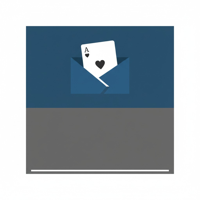

------------------------------------------------------------------
Inference: Ace up your sleeve
Path: img\Idiom\Minimalist\add_fuel_to_the_fire(Minimalist-Style).jpg
Item: add fuel to the fire


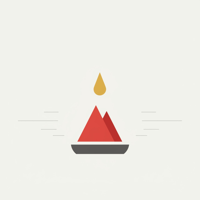

------------------------------------------------------------------
Inference: A drop in the bucket
Path: img\Idiom\Minimalist\against_the_clock(Minimalist-Style).jpg
Item: against the clock


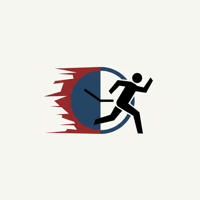

------------------------------------------------------------------
Inference: Race against time
Path: img\Idiom\Minimalist\all_ears(Minimalist-Style).jpg
Item: all ears


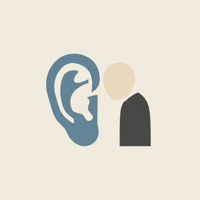

------------------------------------------------------------------
Inference: All ears
Path: img\Idiom\Minimalist\all_the_bells_and_whistles(Minimalist-Style).jpg
Item: all the bells and whistles


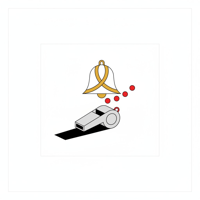

------------------------------------------------------------------
Inference: Bells and whistles
Path: img\Idiom\Minimalist\all_thumbs(Minimalist-Style).jpg
Item: all thumbs


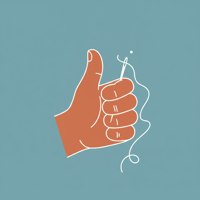

------------------------------------------------------------------
Inference: All thumbs (or "A green thumb" variant, but most likely "Rule of thumb")
Path: img\Idiom\Minimalist\ants_in_one's_pants(Minimalist-Style).jpg
Item: ants in one's pants


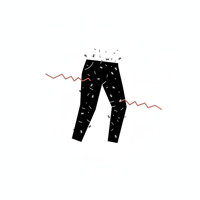

------------------------------------------------------------------
Inference: Ants in your pants
Path: img\Idiom\Minimalist\apple_of_one's_eye(Minimalist-Style).jpg
Item: apple of one's eye


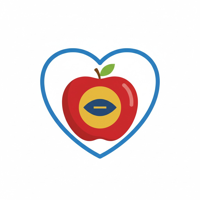

------------------------------------------------------------------
Inference: Apple of my eye
Path: img\Idiom\Minimalist\apple_polisher(Minimalist-Style).jpg
Item: apple polisher


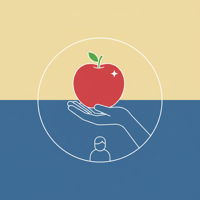

------------------------------------------------------------------
Inference: Apple of my eye
Path: img\Idiom\Minimalist\armchair_critic(Minimalist-Style).jpg
Item: armchair critic


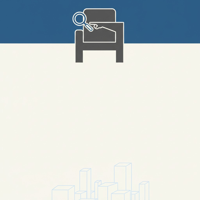

------------------------------------------------------------------
Inference: Armchair critic
Path: img\Idiom\Minimalist\as_blind_as_a_bat(Minimalist-Style).jpg
Item: as blind as a bat


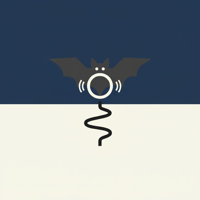

------------------------------------------------------------------
Inference: Bat out of hell
Path: img\Idiom\Minimalist\as_busy_as_a_bee(Minimalist-Style).jpg
Item: as busy as a bee


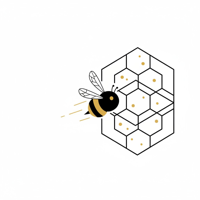

------------------------------------------------------------------
Inference: Busy as a bee
Path: img\Idiom\Minimalist\as_wise_as_an_owl(Minimalist-Style).jpg
Item: as wise as an owl


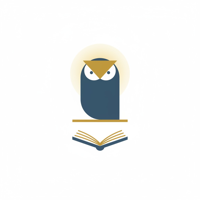

------------------------------------------------------------------
Inference: Wise old owl
Path: img\Idiom\Minimalist\at_the_end_of_one's_rope(Minimalist-Style).jpg
Item: at the end of one's rope


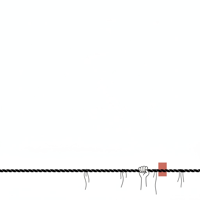

------------------------------------------------------------------
Inference: Hang in there/At the end of one's rope
Path: img\Idiom\Minimalist\axe_to_grind(Minimalist-Style).jpg
Item: axe to grind


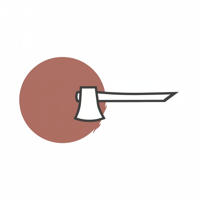

------------------------------------------------------------------
Inference: An axe to grind
Path: img\Idiom\Minimalist\a_big_fish_in_a_small_pond(Minimalist-Style).jpg
Item: a big fish in a small pond


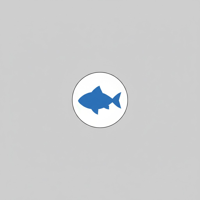

------------------------------------------------------------------
Inference: Life in a fishbowl
Path: img\Idiom\Minimalist\a_bird_in_the_hand_is_worth_two_in_the_bush(Minimalist-Style).jpg
Item: a bird in the hand is worth two in the bush


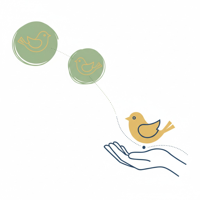

------------------------------------------------------------------
Inference: A bird in the hand is worth two in the bush
Path: img\Idiom\Minimalist\a_brush_with_death(Minimalist-Style).jpg
Item: a brush with death


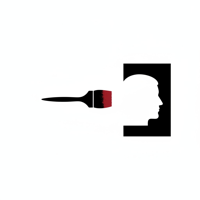

------------------------------------------------------------------
Inference: Paint a picture
Path: img\Idiom\Minimalist\a_can_of_worms(Minimalist-Style).jpg
Item: a can of worms


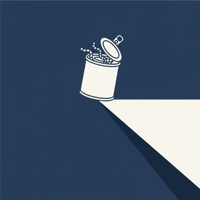

------------------------------------------------------------------
Inference: Can of worms
Path: img\Idiom\Minimalist\a_chip_on_one's_shoulder(Minimalist-Style).jpg
Item: a chip on one's shoulder


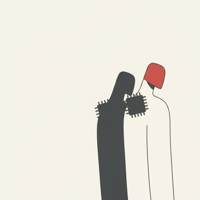

------------------------------------------------------------------
Inference: A chip on your shoulder
Path: img\Idiom\Minimalist\a_drop_in_the_bucket(Minimalist-Style).jpg
Item: a drop in the bucket


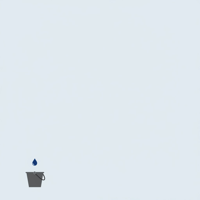

------------------------------------------------------------------
Inference: A drop in the bucket
Path: img\Idiom\Minimalist\a_feather_in_one's_cap(Minimalist-Style).jpg
Item: a feather in one's cap


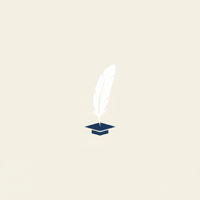

------------------------------------------------------------------
Inference: A feather in your cap
Path: img\Idiom\Minimalist\a_fly_on_the_wall(Minimalist-Style).jpg
Item: a fly on the wall


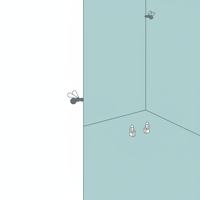

------------------------------------------------------------------
Inference: Fly on the wall
Path: img\Idiom\Minimalist\a_little_bird_told_me(Minimalist-Style).jpg
Item: a little bird told me


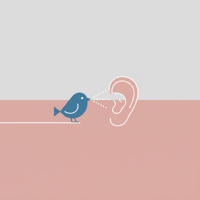

------------------------------------------------------------------
Inference: A little bird told me
Path: img\Idiom\Minimalist\a_piece_of_the_puzzle(Minimalist-Style).jpg
Item: a piece of the puzzle


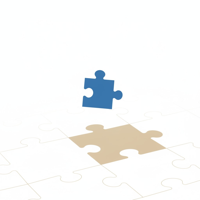

------------------------------------------------------------------
Inference: The missing piece of the puzzle
Path: img\Idiom\Minimalist\backseat_driver(Minimalist-Style).jpg
Item: backseat driver


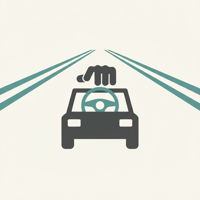

------------------------------------------------------------------
Inference: In the driver's seat
Path: img\Idiom\Minimalist\back_to_the_drawing_board(Minimalist-Style).jpg
Item: back to the drawing board


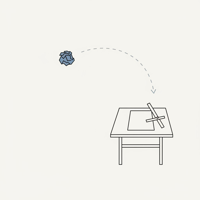

------------------------------------------------------------------
Inference: Back to the drawing board
Path: img\Idiom\Minimalist\bad_apple(Minimalist-Style).jpg
Item: bad apple


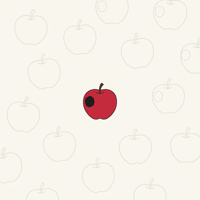

------------------------------------------------------------------
Inference: Bad apple
Path: img\Idiom\Minimalist\balance_the_books(Minimalist-Style).jpg
Item: balance the books


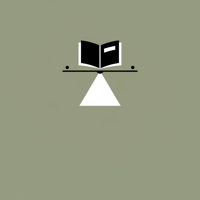

------------------------------------------------------------------
Inference: Work-life balance
Path: img\Idiom\Minimalist\barking_up_the_wrong_tree(Minimalist-Style).jpg
Item: barking up the wrong tree


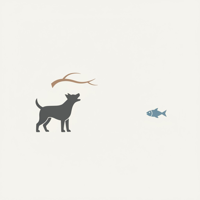

------------------------------------------------------------------
Inference: Barking up the wrong tree
Path: img\Idiom\Minimalist\basket_case(Minimalist-Style).jpg
Item: basket case


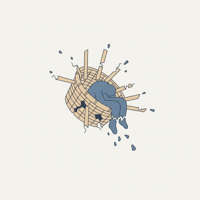

------------------------------------------------------------------
Inference: Basket case
Path: img\Idiom\Minimalist\bats_in_the_belfry(Minimalist-Style).jpg
Item: bats in the belfry


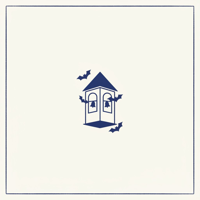

------------------------------------------------------------------
Inference: Bats in the belfry
Path: img\Idiom\Minimalist\bear_in_mind(Minimalist-Style).jpg
Item: bear in mind


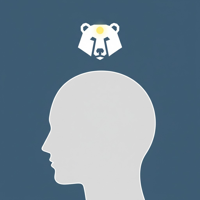

------------------------------------------------------------------
Inference: Bear in mind
Path: img\Idiom\Minimalist\beat_around_the_bush(Minimalist-Style).jpg
Item: beat around the bush


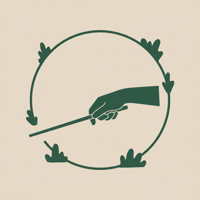

------------------------------------------------------------------
Inference: Beat around the bush
Path: img\Idiom\Minimalist\bed_of_roses(Minimalist-Style).jpg
Item: bed of roses


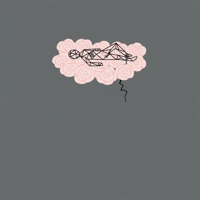

------------------------------------------------------------------
Inference: Bed of roses
Path: img\Idiom\Minimalist\behind_bars(Minimalist-Style).jpg
Item: behind bars


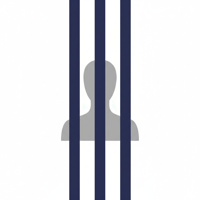

------------------------------------------------------------------
Inference: Behind bars
Path: img\Idiom\Minimalist\bend_over_backwards(Minimalist-Style).jpg
Item: bend over backwards


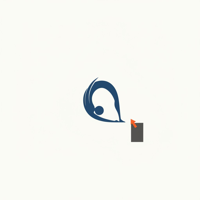

------------------------------------------------------------------
Inference: Dive headfirst into something
Path: img\Idiom\Minimalist\big_cheese(Minimalist-Style).jpg
Item: big cheese


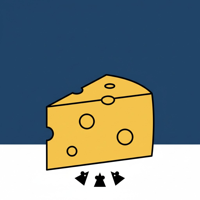

------------------------------------------------------------------
Inference: The big cheese
Path: img\Idiom\Minimalist\bird_brain(Minimalist-Style).jpg
Item: bird brain


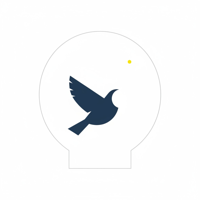

------------------------------------------------------------------
Inference: Canary in a coal mine
Path: img\Idiom\Minimalist\bite_someone's_head_off(Minimalist-Style).jpg
Item: bite someone's head off


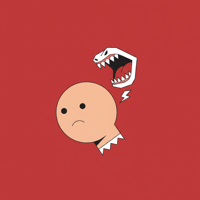

------------------------------------------------------------------
Inference: Bite someone's head off
Path: img\Idiom\Minimalist\bite_the_bullet(Minimalist-Style).jpg
Item: bite the bullet


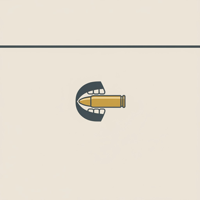

------------------------------------------------------------------
Inference: Bite the bullet
Path: img\Idiom\Minimalist\bite_the_dust(Minimalist-Style).jpg
Item: bite the dust


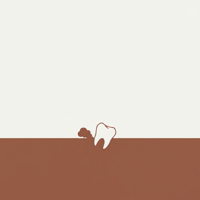

------------------------------------------------------------------
Inference: Sweet tooth (Alternative: Brain fart or Tooth fart, but most commonly associated with "Talking out of your tooth" or the visual pun for **Sweet tooth**)
Path: img\Idiom\Minimalist\black_sheep_of_the_family(Minimalist-Style).jpg
Item: black sheep of the family


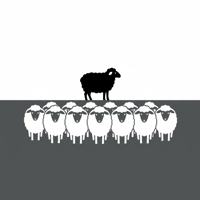

------------------------------------------------------------------
Inference: Black sheep
Path: img\Idiom\Minimalist\blanket_coverage(Minimalist-Style).jpg
Item: blanket coverage


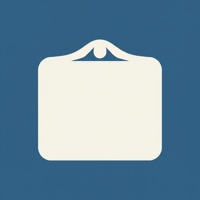

------------------------------------------------------------------
Inference: Think outside the box
Path: img\Idiom\Minimalist\blind_date(Minimalist-Style).jpg
Item: blind date


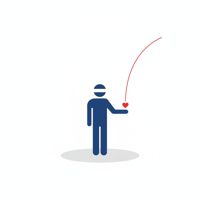

------------------------------------------------------------------
Inference: Love is blind
Path: img\Idiom\Minimalist\blow_one's_mind(Minimalist-Style).jpg
Item: blow one's mind


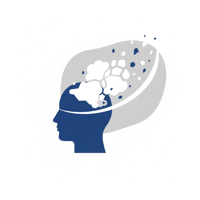

------------------------------------------------------------------
Inference: Mind-blown
Path: img\Idiom\Minimalist\blow_one's_own_trumpet(Minimalist-Style).jpg
Item: blow one's own trumpet


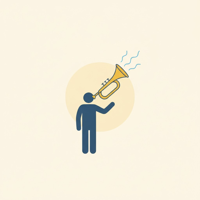

------------------------------------------------------------------
Inference: Blow your own trumpet
Path: img\Idiom\Minimalist\blow_one's_top(Minimalist-Style).jpg
Item: blow one's top


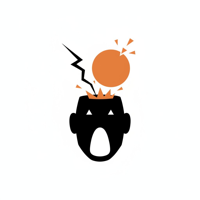

------------------------------------------------------------------
Inference: Mind-blown
Path: img\Idiom\Minimalist\blue_collar(Minimalist-Style).jpg
Item: blue collar


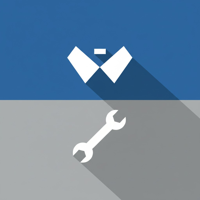

------------------------------------------------------------------
Inference: Blue-collar and white-collar workers
Path: img\Idiom\Minimalist\boiling_frog(Minimalist-Style).jpg
Item: boiling frog


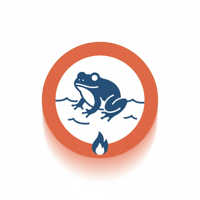

------------------------------------------------------------------
Inference: Boiling frog syndrome
Path: img\Idiom\Minimalist\born_with_a_silver_spoon_in_one's_mouth(Minimalist-Style).jpg
Item: born with a silver spoon in one's mouth


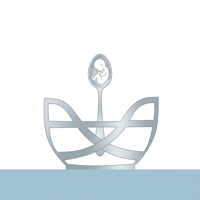

------------------------------------------------------------------
Inference: Born with a silver spoon in one's mouth
Path: img\Idiom\Minimalist\brain_versus_brawn(Minimalist-Style).jpg
Item: brain versus brawn


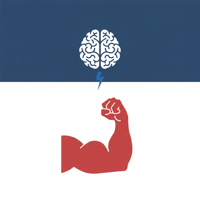

------------------------------------------------------------------
Inference: Brainstorm
Path: img\Idiom\Minimalist\break_a_leg(Minimalist-Style).jpg
Item: break a leg


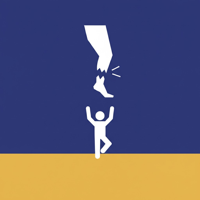

------------------------------------------------------------------
Inference: Break a leg
Path: img\Idiom\Minimalist\break_the_ice(Minimalist-Style).jpg
Item: break the ice


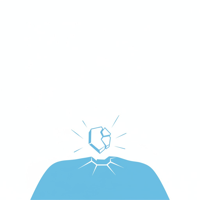

------------------------------------------------------------------
Inference: Break the ice
Path: img\Idiom\Minimalist\bring_home_the_bacon(Minimalist-Style).jpg
Item: bring home the bacon


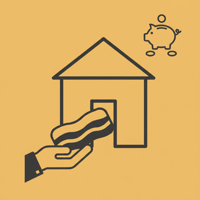

------------------------------------------------------------------
Inference: Bring home the bacon
Path: img\Idiom\Minimalist\broken_heart(Minimalist-Style).jpg
Item: broken heart


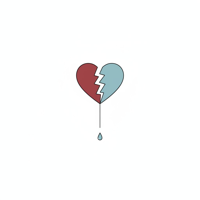

------------------------------------------------------------------
Inference: Broken heart
Path: img\Idiom\Minimalist\bull's_eye(Minimalist-Style).jpg
Item: bull's eye


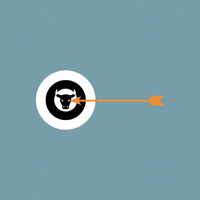

------------------------------------------------------------------
Inference: Bullseye
Path: img\Idiom\Minimalist\bull_in_a_china_shop(Minimalist-Style).jpg
Item: bull in a china shop


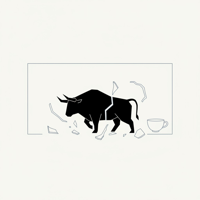

------------------------------------------------------------------
Inference: Bull in a china shop
Path: img\Idiom\Minimalist\burn_one's_bridges(Minimalist-Style).jpg
Item: burn one's bridges


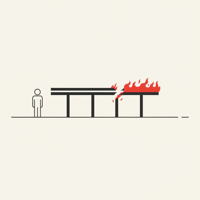

------------------------------------------------------------------
Inference: Burning bridges
Path: img\Idiom\Minimalist\burn_the_candle_at_both_ends(Minimalist-Style).jpg
Item: burn the candle at both ends


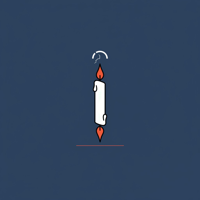

------------------------------------------------------------------
Inference: Burning the candle at both ends
Path: img\Idiom\Minimalist\burn_the_midnight_oil(Minimalist-Style).jpg
Item: burn the midnight oil


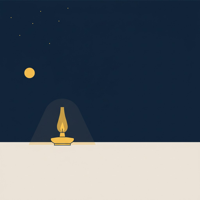

------------------------------------------------------------------
Inference: Burn the midnight oil
Path: img\Idiom\Minimalist\bury_one's_head_in_the_sand(Minimalist-Style).jpg
Item: bury one's head in the sand


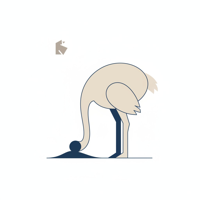

------------------------------------------------------------------
Inference: Bury your head in the sand
Path: img\Idiom\Minimalist\bury_the_hatchet(Minimalist-Style).jpg
Item: bury the hatchet


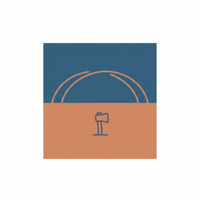

------------------------------------------------------------------
Inference: Bury the hatchet
Path: img\Idiom\Minimalist\butterflies_in_one's_stomach(Minimalist-Style).jpg
Item: butterflies in one's stomach


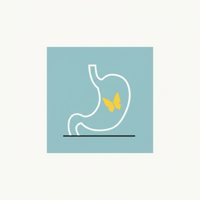

------------------------------------------------------------------
Inference: Butterflies in your stomach
Path: img\Idiom\Minimalist\butter_someone_up(Minimalist-Style).jpg
Item: butter someone up


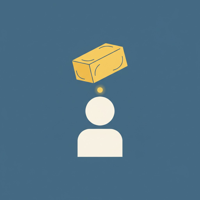

------------------------------------------------------------------
Inference: Mental block
Path: img\Idiom\Minimalist\canary_in_a_coal_mine(Minimalist-Style).jpg
Item: canary in a coal mine


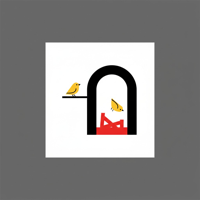

------------------------------------------------------------------
Inference: Canary in a coal mine
Path: img\Idiom\Minimalist\carrot_and_stick(Minimalist-Style).jpg
Item: carrot and stick


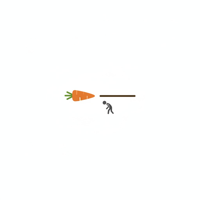

------------------------------------------------------------------
Inference: Carrot on a stick
Path: img\Idiom\Minimalist\cash_cow(Minimalist-Style).jpg
Item: cash cow


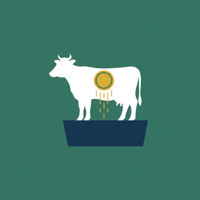

------------------------------------------------------------------
Inference: Cash cow
Path: img\Idiom\Minimalist\castle_in_the_air(Minimalist-Style).jpg
Item: castle in the air


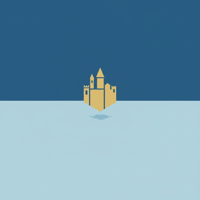

------------------------------------------------------------------
Inference: Castles in the air
Path: img\Idiom\Minimalist\cast_iron_stomach(Minimalist-Style).jpg
Item: cast iron stomach


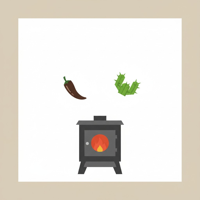

------------------------------------------------------------------
Inference: Hot as an oven
Path: img\Idiom\Minimalist\catch_some_Zs(Minimalist-Style).jpg
Item: catch some Zs


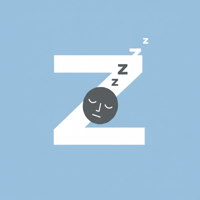

------------------------------------------------------------------
Inference: Catch some Z's
Path: img\Idiom\Minimalist\cat_burglar(Minimalist-Style).jpg
Item: cat burglar


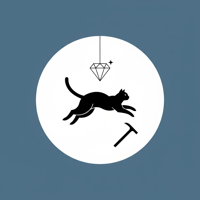

------------------------------------------------------------------
Inference: Cat burglar
Path: img\Idiom\Minimalist\cat_got_one's_tongue(Minimalist-Style).jpg
Item: cat got one's tongue


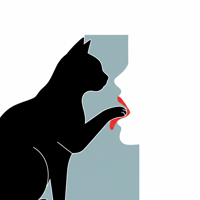

------------------------------------------------------------------
Inference: Cat got your tongue?
Path: img\Idiom\Minimalist\caught_red-handed(Minimalist-Style).jpg
Item: caught red-handed


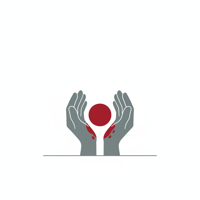

------------------------------------------------------------------
Inference: Caught red-handed
Path: img\Idiom\Minimalist\chain_smoker(Minimalist-Style).jpg
Item: chain smoker


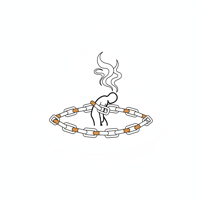

------------------------------------------------------------------
Inference: Chain smoker
Path: img\Idiom\Minimalist\chasing_rainbows(Minimalist-Style).jpg
Item: chasing rainbows


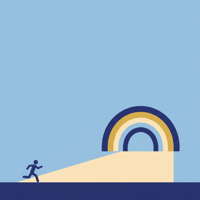

------------------------------------------------------------------
Inference: Chasing rainbows
Path: img\Idiom\Minimalist\chicken_out(Minimalist-Style).jpg
Item: chicken out


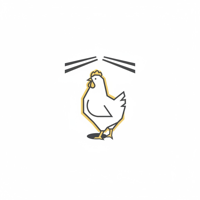

------------------------------------------------------------------
Inference: Chicken coop
Path: img\Idiom\Minimalist\chip_off_the_old_block(Minimalist-Style).jpg
Item: chip off the old block


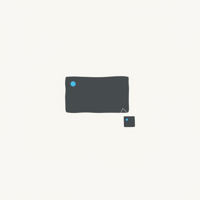

------------------------------------------------------------------
Inference: A chip off the old block
Path: img\Idiom\Minimalist\clam_up(Minimalist-Style).jpg
Item: clam up


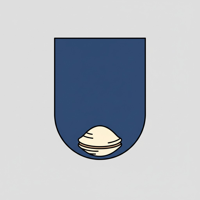

------------------------------------------------------------------
Inference: Happy as a clam
Path: img\Idiom\Minimalist\close_shave(Minimalist-Style).jpg
Item: close shave


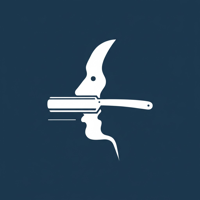

------------------------------------------------------------------
Inference: Occam's razor
Path: img\Idiom\Minimalist\cold_feet(Minimalist-Style).jpg
Item: cold feet


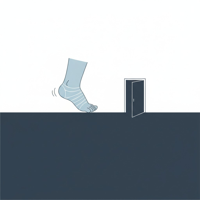

------------------------------------------------------------------
Inference: Foot in the door
Path: img\Idiom\Minimalist\cold_shoulder(Minimalist-Style).jpg
Item: cold shoulder


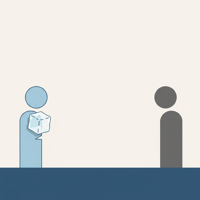

------------------------------------------------------------------
Inference: Break the ice
Path: img\Idiom\Minimalist\cold_turkey(Minimalist-Style).jpg
Item: cold turkey


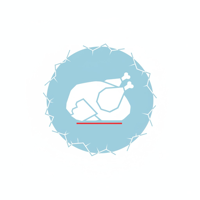

------------------------------------------------------------------
Inference: Cold turkey
Path: img\Idiom\Minimalist\come_out_of_one's_shell(Minimalist-Style).jpg
Item: come out of one's shell


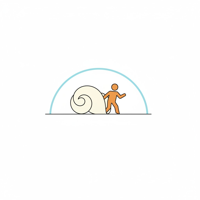

------------------------------------------------------------------
Inference: Come out of your shell
Path: img\Idiom\Minimalist\cook_the_books(Minimalist-Style).jpg
Item: cook the books


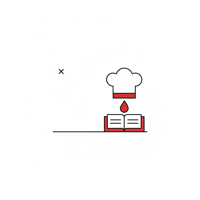

------------------------------------------------------------------
Inference: Cook the books
Path: img\Idiom\Minimalist\cool_as_a_cucumber(Minimalist-Style).jpg
Item: cool as a cucumber


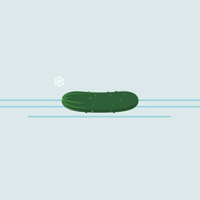

------------------------------------------------------------------
Inference: Cool as a cucumber
Path: img\Idiom\Minimalist\cost_an_arm_and_a_leg(Minimalist-Style).jpg
Item: cost an arm and a leg


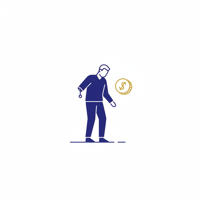

------------------------------------------------------------------
Inference: Costs an arm and a leg
Path: img\Idiom\Minimalist\couch_potato(Minimalist-Style).jpg
Item: couch potato


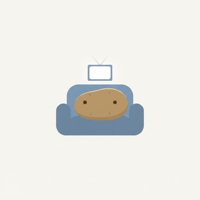

------------------------------------------------------------------
Inference: Couch potato
Path: img\Idiom\Minimalist\crack_the_whip(Minimalist-Style).jpg
Item: crack the whip


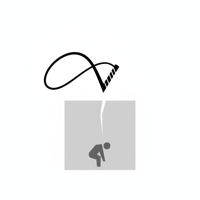

------------------------------------------------------------------
Inference: In the loop
Path: img\Idiom\Minimalist\crocodile_tears(Minimalist-Style).jpg
Item: crocodile tears


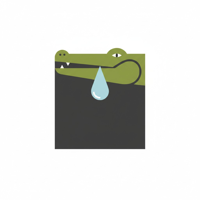

------------------------------------------------------------------
Inference: Crocodile tears
Path: img\Idiom\Minimalist\cross_one's_fingers(Minimalist-Style).jpg
Item: cross one's fingers


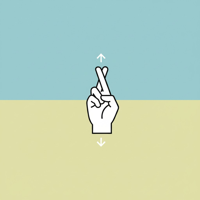

------------------------------------------------------------------
Inference: Fingers crossed high and low
Path: img\Idiom\Minimalist\cry_over_spilled_milk(Minimalist-Style).jpg
Item: cry over spilled milk


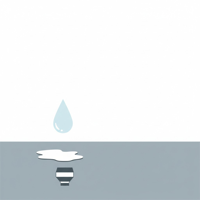

------------------------------------------------------------------
Inference: A drop in the ocean
Path: img\Idiom\Minimalist\cry_wolf(Minimalist-Style).jpg
Item: cry wolf


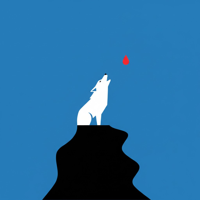

------------------------------------------------------------------
Inference: Blood moon
Path: img\Idiom\Minimalist\cut_corners(Minimalist-Style).jpg
Item: cut corners


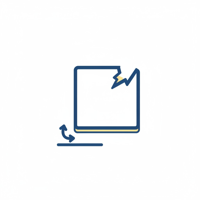

------------------------------------------------------------------
Inference: Turn over a new leaf
Path: img\Idiom\Minimalist\dark_horse(Minimalist-Style).jpg
Item: dark horse


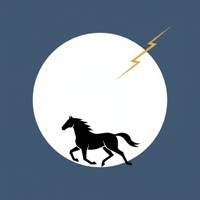

------------------------------------------------------------------
Inference: Dark horse
Path: img\Idiom\Minimalist\dead_end(Minimalist-Style).jpg
Item: dead end


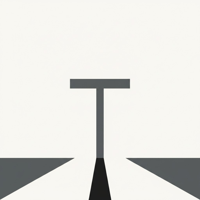

------------------------------------------------------------------
Inference: To a T
Path: img\Idiom\Minimalist\devil's_advocate(Minimalist-Style).jpg
Item: devil's advocate


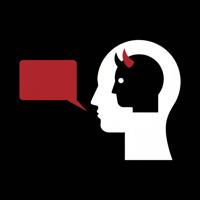

------------------------------------------------------------------
Inference: Speak of the devil
Path: img\Idiom\Minimalist\down_in_the_dumps(Minimalist-Style).jpg
Item: down in the dumps


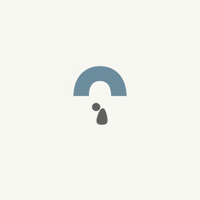

------------------------------------------------------------------
Inference: Under the weather
Path: img\Idiom\Minimalist\drag_one's_feet(Minimalist-Style).jpg
Item: drag one's feet


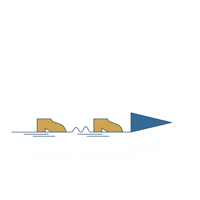

------------------------------------------------------------------
Inference: In deep water
Path: img\Idiom\Minimalist\dressed_to_kill(Minimalist-Style).jpg
Item: dressed to kill


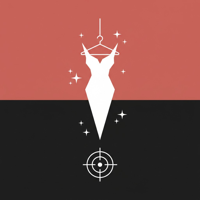

------------------------------------------------------------------
Inference: Dressed to kill
Path: img\Idiom\Minimalist\drink_like_a_fish(Minimalist-Style).jpg
Item: drink like a fish


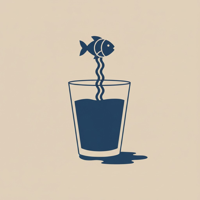

------------------------------------------------------------------
Inference: Drink like a fish
Path: img\Idiom\Minimalist\drive_someone_bananas(Minimalist-Style).jpg
Item: drive someone bananas


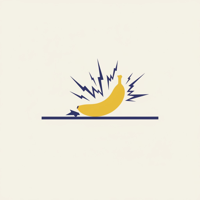

------------------------------------------------------------------
Inference: Go bananas
Path: img\Idiom\Minimalist\drive_someone_up_the_wall(Minimalist-Style).jpg
Item: drive someone up the wall


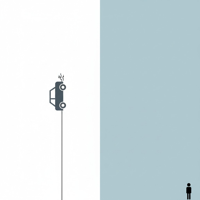

------------------------------------------------------------------
Inference: Car match (Karma)
Path: img\Idiom\Minimalist\drop_the_ball(Minimalist-Style).jpg
Item: drop the ball


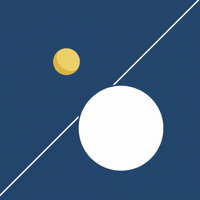

------------------------------------------------------------------
Inference: Percentage
Path: img\Idiom\Minimalist\drunk_as_a_skunk(Minimalist-Style).jpg
Item: drunk as a skunk


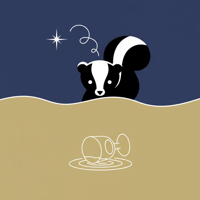

------------------------------------------------------------------
Inference: Drunk as a skunk
Path: img\Idiom\Minimalist\eager_beaver(Minimalist-Style).jpg
Item: eager beaver


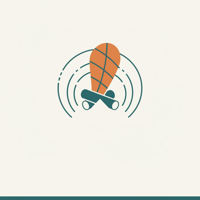

------------------------------------------------------------------
Inference: Ring of fire
Path: img\Idiom\Minimalist\early_bird_catches_the_worm(Minimalist-Style).jpg
Item: early bird catches the worm


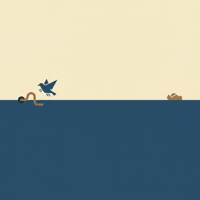

------------------------------------------------------------------
Inference: The early bird catches the worm
Path: img\Idiom\Minimalist\eat_crow(Minimalist-Style).jpg
Item: eat crow


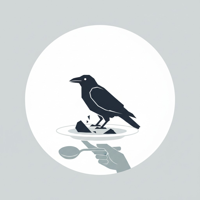

------------------------------------------------------------------
Inference: Eat crow
Path: img\Idiom\Minimalist\eat_one's_words(Minimalist-Style).jpg
Item: eat one's words


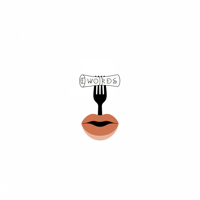

------------------------------------------------------------------
Inference: Eat your words
Path: img\Idiom\Minimalist\egg_on_one's_face(Minimalist-Style).jpg
Item: egg on one's face


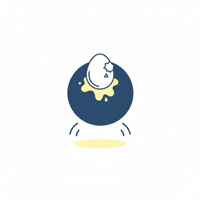

------------------------------------------------------------------
Inference: Egg on your face
Path: img\Idiom\Minimalist\elbow_grease(Minimalist-Style).jpg
Item: elbow grease


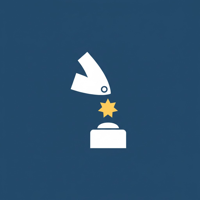

------------------------------------------------------------------
Inference: Lodestar
Path: img\Idiom\Minimalist\elephant_in_the_room(Minimalist-Style).jpg
Item: elephant in the room


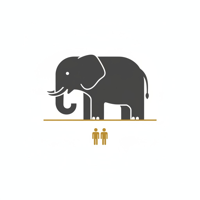

------------------------------------------------------------------
Inference: Elephant in the room
Path: img\Idiom\Minimalist\emotional_baggage(Minimalist-Style).jpg
Item: emotional baggage


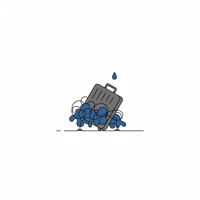

------------------------------------------------------------------
Inference: Emotional baggage
Path: img\Idiom\Minimalist\eye_candy(Minimalist-Style).jpg
Item: eye candy


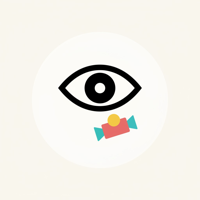

------------------------------------------------------------------
Inference: Eye candy
Path: img\Idiom\Minimalist\face_like_thunder(Minimalist-Style).jpg
Item: face like thunder


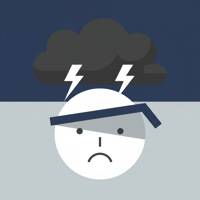

------------------------------------------------------------------
Inference: Under a cloud
Path: img\Idiom\Minimalist\face_the_music(Minimalist-Style).jpg
Item: face the music


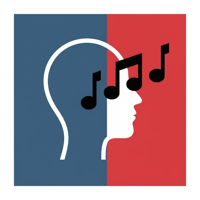

------------------------------------------------------------------
Inference: Music in my head (or Earworm)
Path: img\Idiom\Minimalist\fat_cat(Minimalist-Style).jpg
Item: fat cat


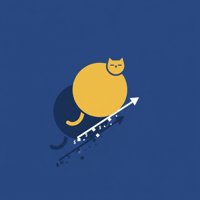

------------------------------------------------------------------
Inference: Fat cat
Path: img\Idiom\Minimalist\feather_one's_nest(Minimalist-Style).jpg
Item: feather one's nest


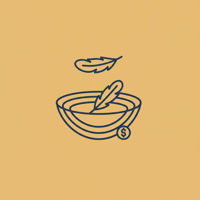

------------------------------------------------------------------
Inference: Nest egg
Path: img\Idiom\Minimalist\feeling_blue(Minimalist-Style).jpg
Item: feeling blue


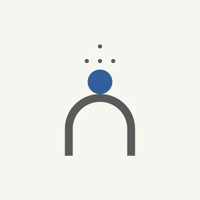

------------------------------------------------------------------
Inference: At the top of the arch
Path: img\Idiom\Minimalist\feet_of_clay(Minimalist-Style).jpg
Item: feet of clay


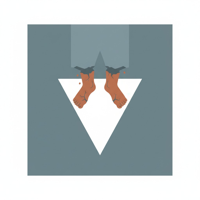

------------------------------------------------------------------
Inference: Feet of clay
Path: img\Idiom\Minimalist\fifth_wheel(Minimalist-Style).jpg
Item: fifth wheel


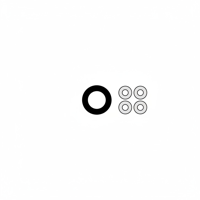

------------------------------------------------------------------
Inference: One for all
Path: img\Idiom\Minimalist\fight_fire_with_fire(Minimalist-Style).jpg
Item: fight fire with fire


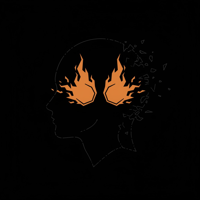

------------------------------------------------------------------
Inference: Burnout
Path: img\Idiom\Minimalist\fishing_for_compliments(Minimalist-Style).jpg
Item: fishing for compliments


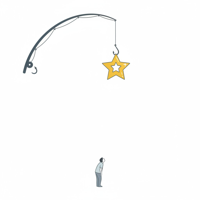

------------------------------------------------------------------
Inference: Reach for the stars
Path: img\Idiom\Minimalist\fish_out_of_water(Minimalist-Style).jpg
Item: fish out of water


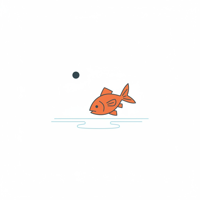

------------------------------------------------------------------
Inference: Fish out of water
Path: img\Idiom\Minimalist\flash_in_the_pan(Minimalist-Style).jpg
Item: flash in the pan


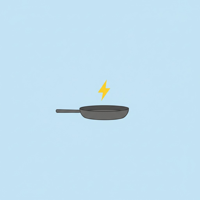

------------------------------------------------------------------
Inference: A flash in the pan
Path: img\Idiom\Minimalist\fly_off_the_handle(Minimalist-Style).jpg
Item: fly off the handle


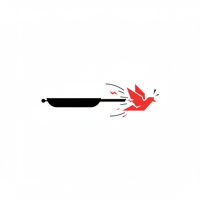

------------------------------------------------------------------
Inference: Out of the frying pan and into the fire
Path: img\Idiom\Minimalist\foaming_at_the_mouth(Minimalist-Style).jpg
Item: foaming at the mouth


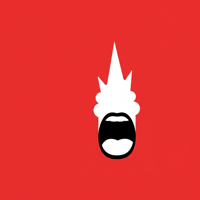

------------------------------------------------------------------
Inference: Piece of cake (alternatively: "Shut your cake hole" or "Screaming for cake," but most likely representing "Eat my dust" or "Cake" in a shouting context, though the most common visual pun here is "Piece of cake" or "Shut your cake hole.")
Path: img\Idiom\Minimalist\follow_in_someone's_footsteps(Minimalist-Style).jpg
Item: follow in someone's footsteps


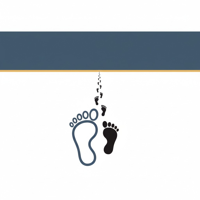

------------------------------------------------------------------
Inference: Follow in someone's footsteps
Path: img\Idiom\Minimalist\follow_the_herd(Minimalist-Style).jpg
Item: follow the herd


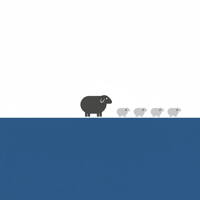

------------------------------------------------------------------
Inference: Black sheep
Path: img\Idiom\Minimalist\food_for_thought(Minimalist-Style).jpg
Item: food for thought


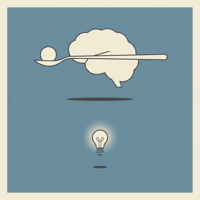

------------------------------------------------------------------
Inference: Spoon-fed
Path: img\Idiom\Minimalist\fork_in_the_road(Minimalist-Style).jpg
Item: fork in the road


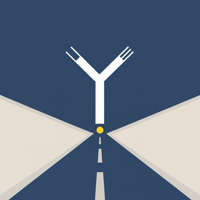

------------------------------------------------------------------
Inference: A fork in the road
Path: img\Idiom\Minimalist\frog_in_one's_throat(Minimalist-Style).jpg
Item: frog in one's throat


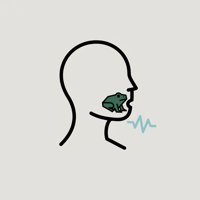

------------------------------------------------------------------
Inference: Frog in your throat
Path: img\Idiom\Minimalist\from_the_bottom_of_one's_heart(Minimalist-Style).jpg
Item: from the bottom of one's heart


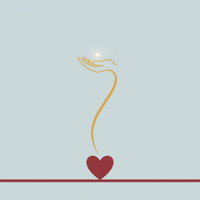

------------------------------------------------------------------
Inference: Wear your heart on your sleeve
Path: img\Idiom\Minimalist\get_off_someone's_back(Minimalist-Style).jpg
Item: get off someone's back


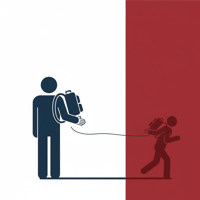

------------------------------------------------------------------
Inference: On a short leash
Path: img\Idiom\Minimalist\get_one's_ducks_in_a_row(Minimalist-Style).jpg
Item: get one's ducks in a row


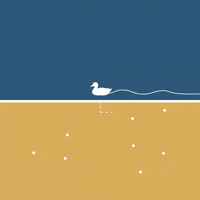

------------------------------------------------------------------
Inference: Duck syndrome (or "Calm on the surface, paddling like crazy underneath")
Path: img\Idiom\Minimalist\get_the_ball_rolling(Minimalist-Style).jpg
Item: get the ball rolling


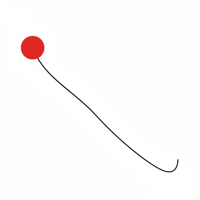

------------------------------------------------------------------
Inference: Period at the end of a sentence
Path: img\Idiom\Minimalist\glass_half_full(Minimalist-Style).jpg
Item: glass half full


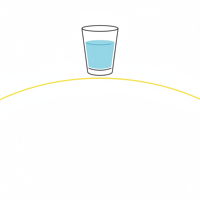

------------------------------------------------------------------
Inference: Glass of water on top of the world
Path: img\Idiom\Minimalist\golden_handshake(Minimalist-Style).jpg
Item: golden handshake


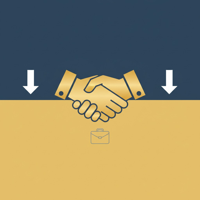

------------------------------------------------------------------
Inference: Shake down a deal
Path: img\Idiom\Minimalist\go_fly_a_kite(Minimalist-Style).jpg
Item: go fly a kite


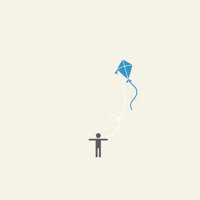

------------------------------------------------------------------
Inference: High as a kite
Path: img\Idiom\Minimalist\gravy_train(Minimalist-Style).jpg
Item: gravy train


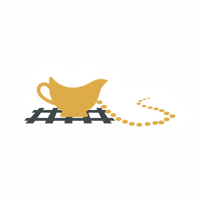

------------------------------------------------------------------
Inference: The gravy train
Path: img\Idiom\Minimalist\green_thumb(Minimalist-Style).jpg
Item: green thumb


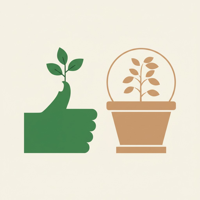

------------------------------------------------------------------
Inference: Green thumb
Path: img\Idiom\Minimalist\green_with_envy(Minimalist-Style).jpg
Item: green with envy


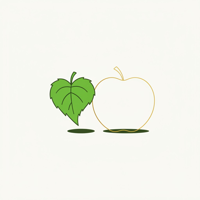

------------------------------------------------------------------
Inference: Apple of my eye
Path: img\Idiom\Minimalist\happy_as_a_clam(Minimalist-Style).jpg
Item: happy as a clam


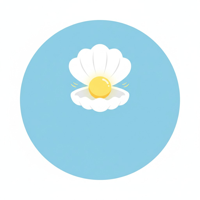

------------------------------------------------------------------
Inference: The world is your oyster
Path: img\Idiom\Minimalist\hard_nut_to_crack(Minimalist-Style).jpg
Item: hard nut to crack


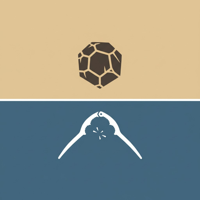

------------------------------------------------------------------
Inference: A tough nut to crack
Path: img\Idiom\Minimalist\have_a_bone_to_pick(Minimalist-Style).jpg
Item: have a bone to pick


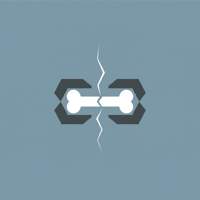

------------------------------------------------------------------
Inference: Break a leg
Path: img\Idiom\Minimalist\have_a_finger_in_every_pie(Minimalist-Style).jpg
Item: have a finger in every pie


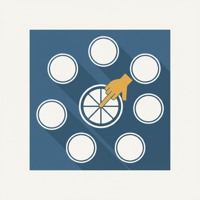

------------------------------------------------------------------
Inference: Finger in every pie
Path: img\Idiom\Minimalist\have_a_heart_of_gold(Minimalist-Style).jpg
Item: have a heart of gold


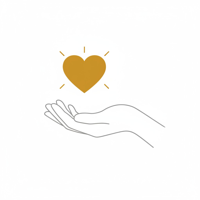

------------------------------------------------------------------
Inference: Heart of gold
Path: img\Idiom\Minimalist\head_in_the_clouds(Minimalist-Style).jpg
Item: head in the clouds


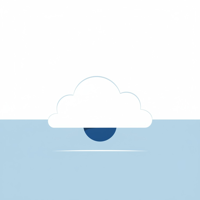

------------------------------------------------------------------
Inference: Every cloud has a silver lining
Path: img\Idiom\Minimalist\head_over_heels(Minimalist-Style).jpg
Item: head over heels


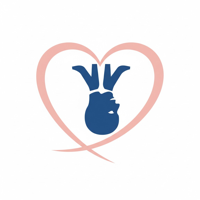

------------------------------------------------------------------
Inference: Head over heels in love
Path: img\Idiom\Minimalist\heard_it_through_the_grapevine(Minimalist-Style).jpg
Item: heard it through the grapevine


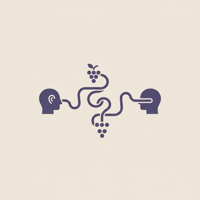

------------------------------------------------------------------
Inference: Heard it through the grapevine
Path: img\Idiom\Minimalist\heart_in_one's_mouth(Minimalist-Style).jpg
Item: heart in one's mouth


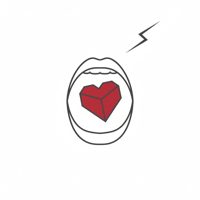

------------------------------------------------------------------
Inference: Heart in mouth
Path: img\Idiom\Minimalist\hit_the_books(Minimalist-Style).jpg
Item: hit the books


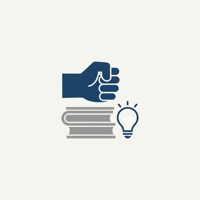

------------------------------------------------------------------
Inference: Hit the books
Path: img\Idiom\Minimalist\hit_the_ceiling(Minimalist-Style).jpg
Item: hit the ceiling


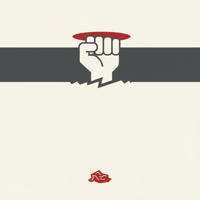

------------------------------------------------------------------
Inference: Glass ceiling
Path: img\Idiom\Minimalist\hit_the_hay(Minimalist-Style).jpg
Item: hit the hay


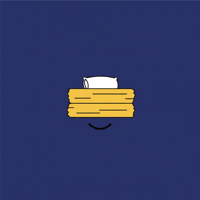

------------------------------------------------------------------
Inference: Sleep on it
Path: img\Idiom\Minimalist\hit_the_nail_on_the_head(Minimalist-Style).jpg
Item: hit the nail on the head


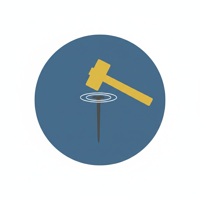

------------------------------------------------------------------
Inference: Hit the nail on the head
Path: img\Idiom\Minimalist\hit_the_road(Minimalist-Style).jpg
Item: hit the road


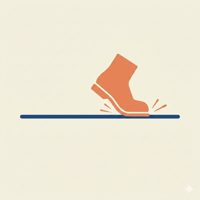

------------------------------------------------------------------
Inference: Put your foot down
Path: img\Idiom\Minimalist\hit_the_sack(Minimalist-Style).jpg
Item: hit the sack


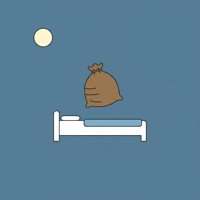

------------------------------------------------------------------
Inference: Hit the sack
Path: img\Idiom\Minimalist\hit_the_spot(Minimalist-Style).jpg
Item: hit the spot


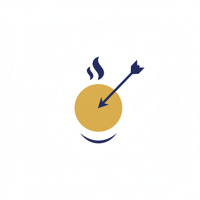

------------------------------------------------------------------
Inference: In the hot spot
Path: img\Idiom\Minimalist\hold_one's_tongue(Minimalist-Style).jpg
Item: hold one's tongue


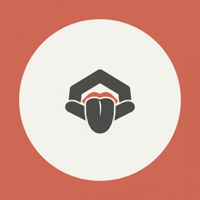

------------------------------------------------------------------
Inference: Tip of the tongue
Path: img\Idiom\Minimalist\hold_your_horses(Minimalist-Style).jpg
Item: hold your horses


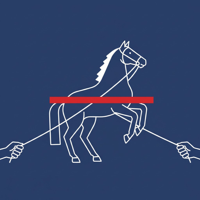

------------------------------------------------------------------
Inference: Hold your horses
Path: img\Idiom\Minimalist\hot_potato(Minimalist-Style).jpg
Item: hot potato


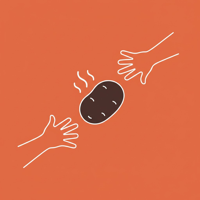

------------------------------------------------------------------
Inference: Hot potato
Path: img\Idiom\Minimalist\hung_out_to_dry(Minimalist-Style).jpg
Item: hung out to dry


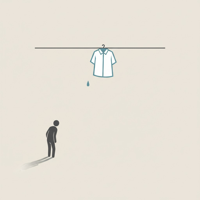

------------------------------------------------------------------
Inference: Like a wet rag (or "Left out to dry")
Path: img\Idiom\Minimalist\icing_on_the_cake(Minimalist-Style).jpg
Item: icing on the cake


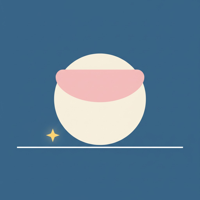

------------------------------------------------------------------
Inference: Tongue twister
Path: img\Idiom\Minimalist\in_a_nutshell(Minimalist-Style).jpg
Item: in a nutshell


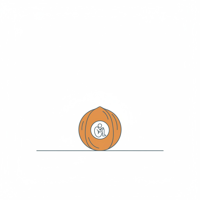

------------------------------------------------------------------
Inference: In a nutshell
Path: img\Idiom\Minimalist\in_a_pickle(Minimalist-Style).jpg
Item: in a pickle


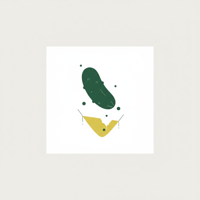

------------------------------------------------------------------
Inference: In a pickle
Path: img\Idiom\Minimalist\in_hot_water(Minimalist-Style).jpg
Item: in hot water


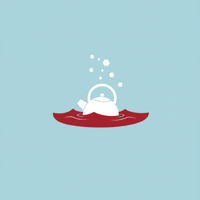

------------------------------------------------------------------
Inference: A tempest in a teapot (or "A storm in a teacup")
Path: img\Idiom\Minimalist\in_the_doghouse(Minimalist-Style).jpg
Item: in the doghouse


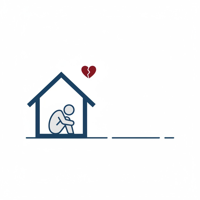

------------------------------------------------------------------
Inference: A broken home
Path: img\Idiom\Minimalist\in_the_limelight(Minimalist-Style).jpg
Item: in the limelight


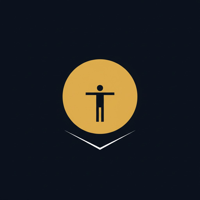

------------------------------------------------------------------
Inference: In the spotlight
Path: img\Idiom\Minimalist\in_the_same_boat(Minimalist-Style).jpg
Item: in the same boat


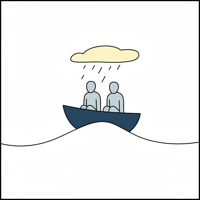

------------------------------------------------------------------
Inference: In the same boat
Path: img\Idiom\Minimalist\itchy_feet(Minimalist-Style).jpg
Item: itchy feet


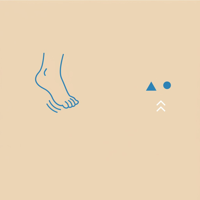

------------------------------------------------------------------
Inference: To tap one's feet
Path: img\Idiom\Minimalist\it_takes_two_to_tango(Minimalist-Style).jpg
Item: it takes two to tango


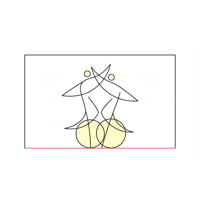

------------------------------------------------------------------
Inference: Two souls on two wheels
Path: img\Idiom\Minimalist\I_could_eat_a_horse(Minimalist-Style).jpg
Item: I could eat a horse


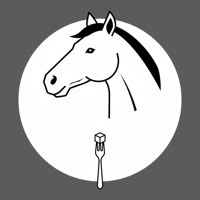

------------------------------------------------------------------
Inference: I could eat a horse
Path: img\Idiom\Minimalist\jump_at_one's_own_shadow(Minimalist-Style).jpg
Item: jump at one's own shadow


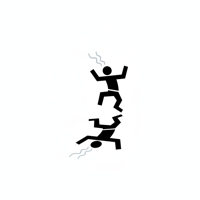

------------------------------------------------------------------
Inference: Head over heels
Path: img\Idiom\Minimalist\jump_for_joy(Minimalist-Style).jpg
Item: jump for joy


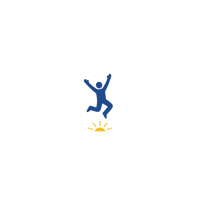

------------------------------------------------------------------
Inference: Jumping for joy
Path: img\Idiom\Minimalist\jump_off_the_page(Minimalist-Style).jpg
Item: jump off the page


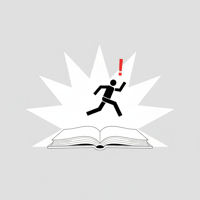

------------------------------------------------------------------
Inference: Jump off the page
Path: img\Idiom\Minimalist\jump_ship(Minimalist-Style).jpg
Item: jump ship


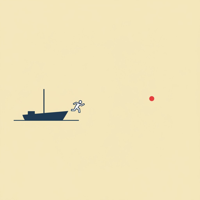

------------------------------------------------------------------
Inference: Abandon ship
Path: img\Idiom\Minimalist\jump_the_shark(Minimalist-Style).jpg
Item: jump the shark


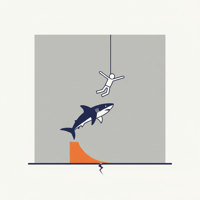

------------------------------------------------------------------
Inference: Jump the shark
Path: img\Idiom\Minimalist\jump_through_hoops(Minimalist-Style).jpg
Item: jump through hoops


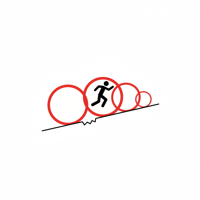

------------------------------------------------------------------
Inference: Jump through hoops
Path: img\Idiom\Minimalist\keep_a_lid_on_it(Minimalist-Style).jpg
Item: keep a lid on it


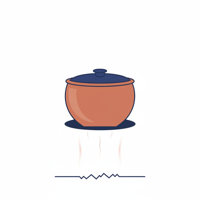

------------------------------------------------------------------
Inference: Pot calling the kettle black
Path: img\Idiom\Minimalist\keep_one's_ear_to_the_ground(Minimalist-Style).jpg
Item: keep one's ear to the ground


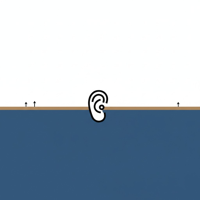

------------------------------------------------------------------
Inference: Ear to the ground
Path: img\Idiom\Minimalist\keep_one's_head_above_water(Minimalist-Style).jpg
Item: keep one's head above water


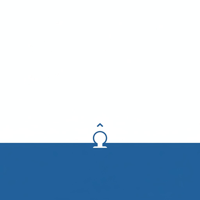

------------------------------------------------------------------
Inference: Keep your head above water
Path: img\Idiom\Minimalist\kick_the_bucket(Minimalist-Style).jpg
Item: kick the bucket


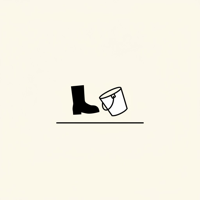

------------------------------------------------------------------
Inference: Kick the bucket
Path: img\Idiom\Minimalist\kick_the_habit(Minimalist-Style).jpg
Item: kick the habit


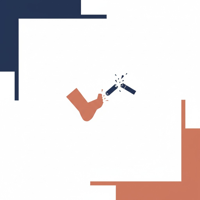

------------------------------------------------------------------
Inference: Break a leg
Path: img\Idiom\Minimalist\killing_time(Minimalist-Style).jpg
Item: killing time


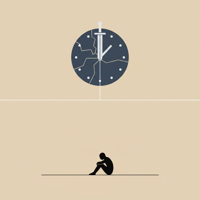

------------------------------------------------------------------
Inference: Damocles sword (or Sword of Damocles)
Path: img\Idiom\Minimalist\kill_two_birds_with_one_stone(Minimalist-Style).jpg
Item: kill two birds with one stone


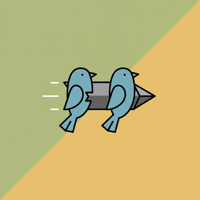

------------------------------------------------------------------
Inference: Kill two birds with one stone
Path: img\Idiom\Minimalist\king_of_the_hill(Minimalist-Style).jpg
Item: king of the hill


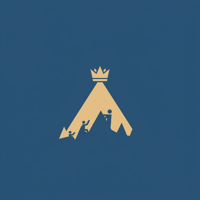

------------------------------------------------------------------
Inference: King of the hill
Path: img\Idiom\Minimalist\knock_on_wood(Minimalist-Style).jpg
Item: knock on wood


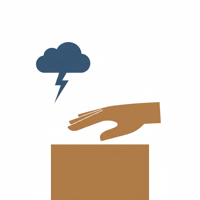

------------------------------------------------------------------
Inference: Lightning in a bottle
Path: img\Idiom\Minimalist\leave_no_stone_unturned(Minimalist-Style).jpg
Item: leave no stone unturned


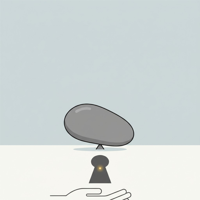

------------------------------------------------------------------
Inference: Leave no stone unturned
Path: img\Idiom\Minimalist\lemon(Minimalist-Style).jpg
Item: lemon


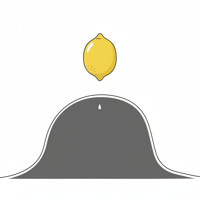

------------------------------------------------------------------
Inference: Lemon Bell Curve
Path: img\Idiom\Minimalist\lend_a_hand(Minimalist-Style).jpg
Item: lend a hand


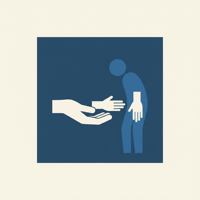

------------------------------------------------------------------
Inference: Lending a helping hand
Path: img\Idiom\Minimalist\let_off_steam(Minimalist-Style).jpg
Item: let off steam


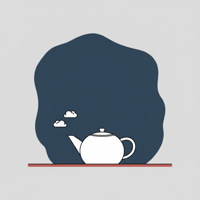

------------------------------------------------------------------
Inference: A tempest in a teapot (or a storm in a teacup)
Path: img\Idiom\Minimalist\let_sleeping_dogs_lie(Minimalist-Style).jpg
Item: let sleeping dogs lie


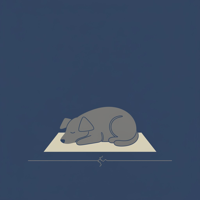

------------------------------------------------------------------
Inference: Let sleeping dogs lie
Path: img\Idiom\Minimalist\let_the_cat_out_of_the_bag(Minimalist-Style).jpg
Item: let the cat out of the bag


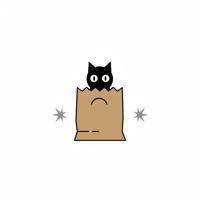

------------------------------------------------------------------
Inference: Let the cat out of the bag
Path: img\Idiom\Minimalist\lick_someone's_boots(Minimalist-Style).jpg
Item: lick someone's boots


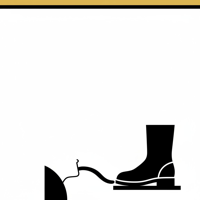

------------------------------------------------------------------
Inference: Bootlicker
Path: img\Idiom\Minimalist\light_at_the_end_of_the_tunnel(Minimalist-Style).jpg
Item: light at the end of the tunnel


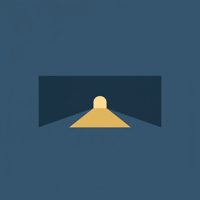

------------------------------------------------------------------
Inference: Light at the end of the tunnel
Path: img\Idiom\Minimalist\like_a_bat_out_of_hell(Minimalist-Style).jpg
Item: like a bat out of hell


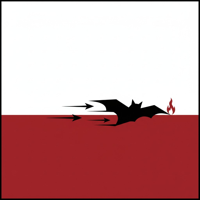

------------------------------------------------------------------
Inference: Like a bat out of hell
Path: img\Idiom\Minimalist\like_a_moth_to_a_flame(Minimalist-Style).jpg
Item: like a moth to a flame


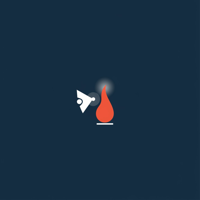

------------------------------------------------------------------
Inference: Like a moth to a flame
Path: img\Idiom\Minimalist\like_chalk_and_cheese(Minimalist-Style).jpg
Item: like chalk and cheese


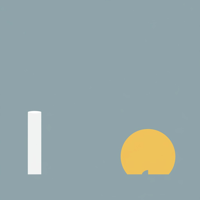

------------------------------------------------------------------
Inference: Chalk and cheese
Path: img\Idiom\Minimalist\like_water_off_a_duck's_back(Minimalist-Style).jpg
Item: like water off a duck's back


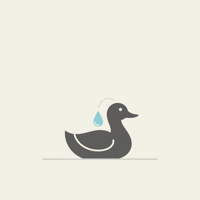

------------------------------------------------------------------
Inference: Like water off a duck's back
Path: img\Idiom\Minimalist\long_shot(Minimalist-Style).jpg
Item: long shot


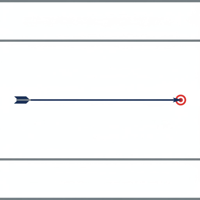

------------------------------------------------------------------
Inference: Straight as an arrow
Path: img\Idiom\Minimalist\lose_one's_head(Minimalist-Style).jpg
Item: lose one's head


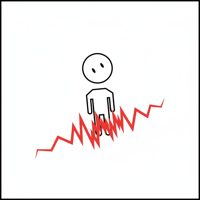

------------------------------------------------------------------
Inference: On the same wavelength
Path: img\Idiom\Minimalist\lose_one's_mind(Minimalist-Style).jpg
Item: lose one's mind


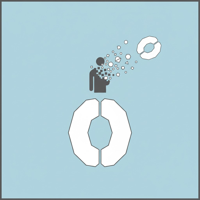

------------------------------------------------------------------
Inference: Losing my mind
Path: img\Idiom\Minimalist\make_a_mountain_out_of_a_molehill(Minimalist-Style).jpg
Item: make a mountain out of a molehill


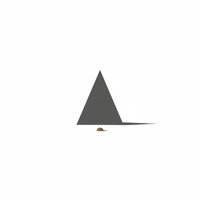

------------------------------------------------------------------
Inference: Making a mountain out of a molehill
Path: img\Idiom\Minimalist\match_made_in_heaven(Minimalist-Style).jpg
Item: match made in heaven


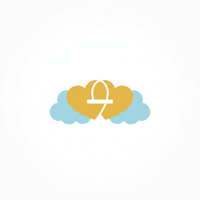

------------------------------------------------------------------
Inference: On cloud nine
Path: img\Idiom\Minimalist\miss_the_boat(Minimalist-Style).jpg
Item: miss the boat


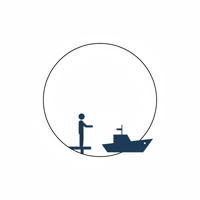

------------------------------------------------------------------
Inference: That ship has sailed
Path: img\Idiom\Minimalist\money_laundering(Minimalist-Style).jpg
Item: money laundering


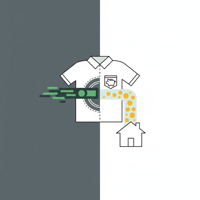

------------------------------------------------------------------
Inference: To lose the shirt off your back/Bet the house (or more generally, Putting everything into your home)
Path: img\Idiom\Minimalist\money_pit(Minimalist-Style).jpg
Item: money pit


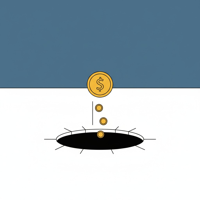

------------------------------------------------------------------
Inference: Money down a hole (or Money pit)
Path: img\Idiom\Minimalist\monkey_business(Minimalist-Style).jpg
Item: monkey business


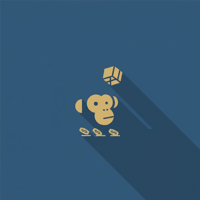

------------------------------------------------------------------
Inference: Monkey business
Path: img\Idiom\Minimalist\monkey_on_one's_back(Minimalist-Style).jpg
Item: monkey on one's back


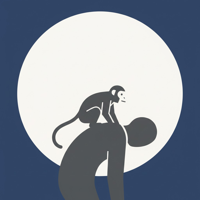

------------------------------------------------------------------
Inference: Monkey on your back
Path: img\Idiom\Minimalist\my_ears_are_burning(Minimalist-Style).jpg
Item: my ears are burning


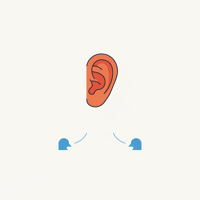

------------------------------------------------------------------
Inference: All ears
Path: img\Idiom\Minimalist\my_hands_are_tied(Minimalist-Style).jpg
Item: my hands are tied


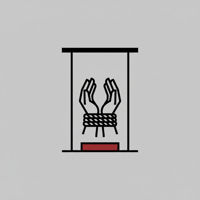

------------------------------------------------------------------
Inference: My hands are tied
Path: img\Idiom\Minimalist\needle_in_a_haystack(Minimalist-Style).jpg
Item: needle in a haystack


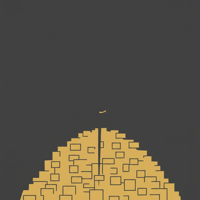

------------------------------------------------------------------
Inference: Needle in a haystack
Path: img\Idiom\Minimalist\nest_egg(Minimalist-Style).jpg
Item: nest egg


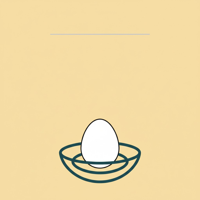

------------------------------------------------------------------
Inference: Nest egg
Path: img\Idiom\Minimalist\night_owl(Minimalist-Style).jpg
Item: night owl


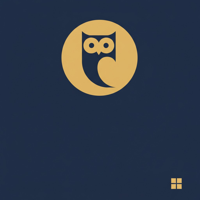

------------------------------------------------------------------
Inference: Night owl
Path: img\Idiom\Minimalist\not_my_cup_of_tea(Minimalist-Style).jpg
Item: not my cup of tea


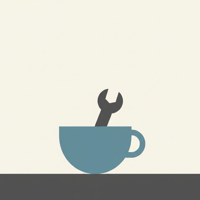

------------------------------------------------------------------
Inference: Spanner in the works
Path: img\Idiom\Minimalist\once_in_a_blue_moon(Minimalist-Style).jpg
Item: once in a blue moon


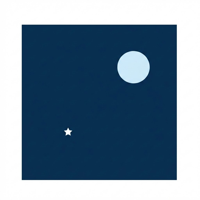

------------------------------------------------------------------
Inference: Once in a blue moon
Path: img\Idiom\Minimalist\one_foot_in_the_grave(Minimalist-Style).jpg
Item: one foot in the grave


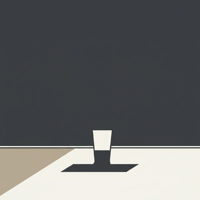

------------------------------------------------------------------
Inference: Is the glass half full or half empty?
Path: img\Idiom\Minimalist\on_cloud_nine(Minimalist-Style).jpg
Item: on cloud nine


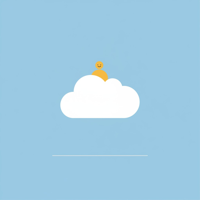

------------------------------------------------------------------
Inference: On cloud nine
Path: img\Idiom\Minimalist\on_pins_and_needles(Minimalist-Style).jpg
Item: on pins and needles


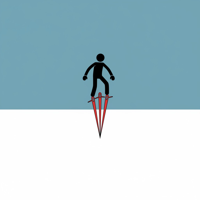

------------------------------------------------------------------
Inference: On pins and needles
Path: img\Idiom\Minimalist\on_the_ball(Minimalist-Style).jpg
Item: on the ball


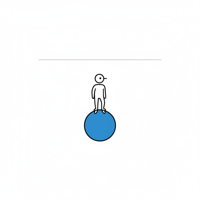

------------------------------------------------------------------
Inference: Sitting on top of the world
Path: img\Idiom\Minimalist\on_the_fence(Minimalist-Style).jpg
Item: on the fence


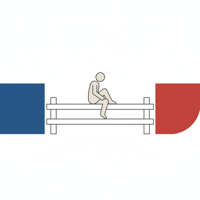

------------------------------------------------------------------
Inference: Sitting on the fence
Path: img\Idiom\Minimalist\on_thin_ice(Minimalist-Style).jpg
Item: on thin ice


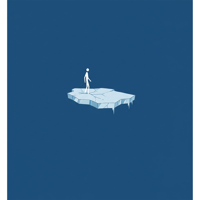

------------------------------------------------------------------
Inference: Walking on thin ice
Path: img\Idiom\Minimalist\on_top_of_the_world(Minimalist-Style).jpg
Item: on top of the world


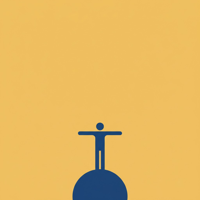

------------------------------------------------------------------
Inference: On top of the world
Path: img\Idiom\Minimalist\out_on_a_limb(Minimalist-Style).jpg
Item: out on a limb


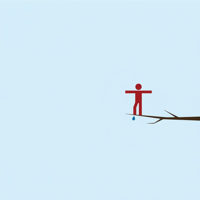

------------------------------------------------------------------
Inference: Out on a limb
Path: img\Idiom\Minimalist\over_the_moon(Minimalist-Style).jpg
Item: over the moon


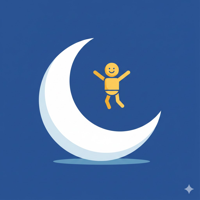

------------------------------------------------------------------
Inference: Over the moon
Path: img\Idiom\Minimalist\paint_oneself_into_a_corner(Minimalist-Style).jpg
Item: paint oneself into a corner


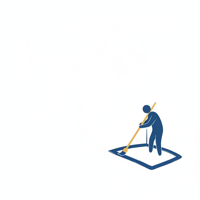

------------------------------------------------------------------
Inference: Paint oneself into a corner
Path: img\Idiom\Minimalist\piece_of_cake(Minimalist-Style).jpg
Item: piece of cake


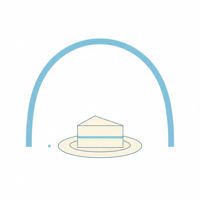

------------------------------------------------------------------
Inference: A piece of cake / Cakewalk
Path: img\Idiom\Minimalist\pie_in_the_sky(Minimalist-Style).jpg
Item: pie in the sky


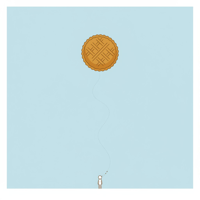

------------------------------------------------------------------
Inference: Pie in the sky
Path: img\Idiom\Minimalist\play_it_by_ear(Minimalist-Style).jpg
Item: play it by ear


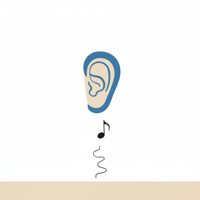

------------------------------------------------------------------
Inference: Earworm
Path: img\Idiom\Minimalist\play_on_words(Minimalist-Style).jpg
Item: play on words


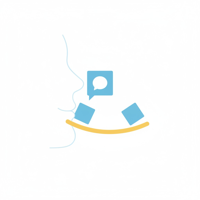

------------------------------------------------------------------
Inference: Break the ice
Path: img\Idiom\Minimalist\play_with_fire(Minimalist-Style).jpg
Item: play with fire


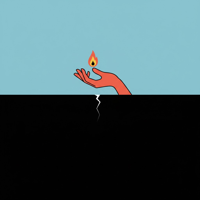

------------------------------------------------------------------
Inference: Playing with fire
Path: img\Idiom\Minimalist\poker_face(Minimalist-Style).jpg
Item: poker face


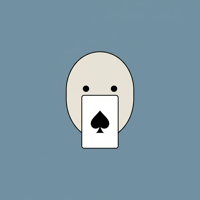

------------------------------------------------------------------
Inference: Call a spade a spade
Path: img\Idiom\Minimalist\pot_calling_the_kettle_black(Minimalist-Style).jpg
Item: pot calling the kettle black


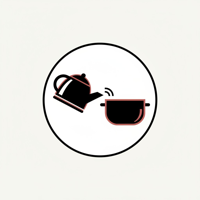

------------------------------------------------------------------
Inference: The pot calling the kettle black
Path: img\Idiom\Minimalist\prisoner_of_one's_own_mind(Minimalist-Style).jpg
Item: prisoner of one's own mind


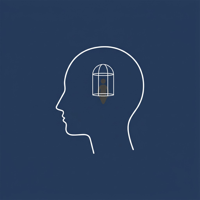

------------------------------------------------------------------
Inference: Prisoner of your own mind
Path: img\Idiom\Minimalist\puppy_love(Minimalist-Style).jpg
Item: puppy love


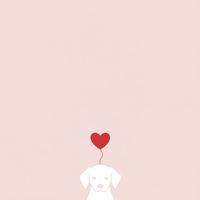

------------------------------------------------------------------
Inference: Puppy love
Path: img\Idiom\Minimalist\put_a_cork_in_it(Minimalist-Style).jpg
Item: put a cork in it


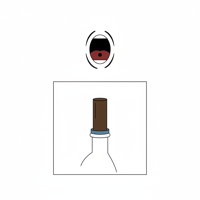

------------------------------------------------------------------
Inference: Cork it
Path: img\Idiom\Minimalist\put_a_sock_in_it(Minimalist-Style).jpg
Item: put a sock in it


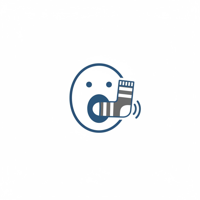

------------------------------------------------------------------
Inference: Put your foot in your mouth
Path: img\Idiom\Minimalist\put_one's_foot_in_one's_mouth(Minimalist-Style).jpg
Item: put one's foot in one's mouth


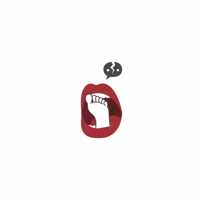

------------------------------------------------------------------
Inference: Put your foot in your mouth
Path: img\Idiom\Minimalist\put_one's_money_where_one's_mouth_is(Minimalist-Style).jpg
Item: put one's money where one's mouth is


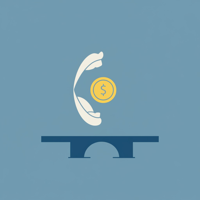

------------------------------------------------------------------
Inference: Money under the bridge
Path: img\Idiom\Minimalist\race_against_time(Minimalist-Style).jpg
Item: race against time


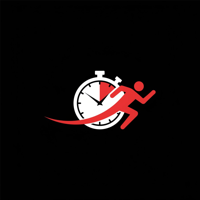

------------------------------------------------------------------
Inference: Race against time
Path: img\Idiom\Minimalist\raining_cats_and_dogs(Minimalist-Style).jpg
Item: raining cats and dogs


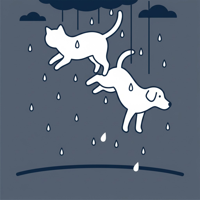

------------------------------------------------------------------
Inference: Raining cats and dogs
Path: img\Idiom\Minimalist\rat_race(Minimalist-Style).jpg
Item: rat race


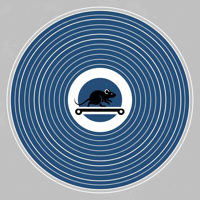

------------------------------------------------------------------
Inference: Rat race
Path: img\Idiom\Minimalist\red_tape(Minimalist-Style).jpg
Item: red tape


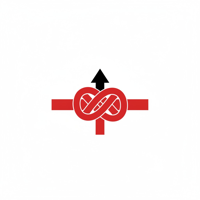

------------------------------------------------------------------
Inference: Tying the knot
Path: img\Idiom\Minimalist\ring_a_bell(Minimalist-Style).jpg
Item: ring a bell


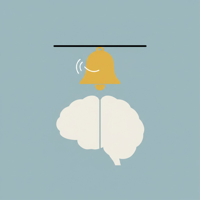

------------------------------------------------------------------
Inference: Ring a bell
Path: img\Idiom\Minimalist\rule_of_thumb(Minimalist-Style).jpg
Item: rule of thumb


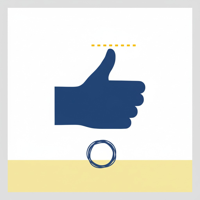

------------------------------------------------------------------
Inference: Rule of thumb
Path: img\Idiom\Minimalist\rule_the_roost(Minimalist-Style).jpg
Item: rule the roost


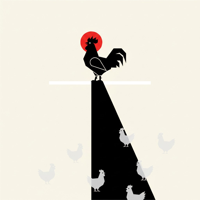

------------------------------------------------------------------
Inference: Rule the roost
Path: img\Idiom\Minimalist\saved_by_the_bell(Minimalist-Style).jpg
Item: saved by the bell


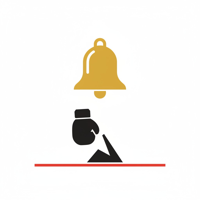

------------------------------------------------------------------
Inference: Saved by the bell
Path: img\Idiom\Minimalist\sitting_duck(Minimalist-Style).jpg
Item: sitting duck


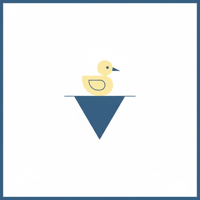

------------------------------------------------------------------
Inference: Duck syndrome
Path: img\Idiom\Minimalist\skeleton_in_the_closet(Minimalist-Style).jpg
Item: skeleton in the closet


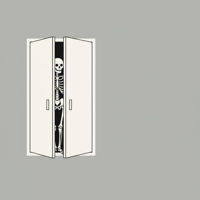

------------------------------------------------------------------
Inference: Skeleton in the closet
Path: img\Idiom\Minimalist\sleep_like_a_log(Minimalist-Style).jpg
Item: sleep like a log


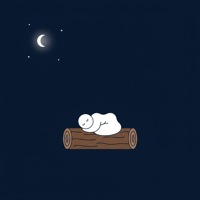

------------------------------------------------------------------
Inference: Sleep like a log
Path: img\Idiom\Minimalist\smart_cookie(Minimalist-Style).jpg
Item: smart cookie


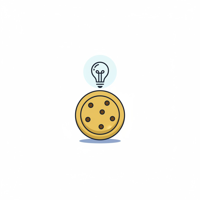

------------------------------------------------------------------
Inference: One smart cookie
Path: img\Idiom\Minimalist\smell_a_rat(Minimalist-Style).jpg
Item: smell a rat


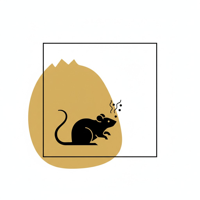

------------------------------------------------------------------
Inference: To smell a rat
Path: img\Idiom\Minimalist\smoke_and_mirrors(Minimalist-Style).jpg
Item: smoke and mirrors


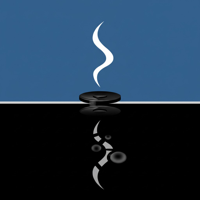

------------------------------------------------------------------
Inference: On the back burner
Path: img\Idiom\Minimalist\snowed_under(Minimalist-Style).jpg
Item: snowed under


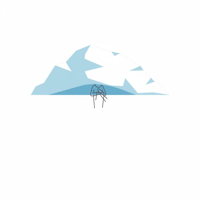

------------------------------------------------------------------
Inference: Tip of the iceberg
Path: img\Idiom\Minimalist\speak_of_the_devil(Minimalist-Style).jpg
Item: speak of the devil


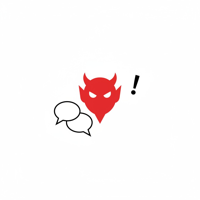

------------------------------------------------------------------
Inference: Speak of the devil
Path: img\Idiom\Minimalist\speak_with_a_forked_tongue(Minimalist-Style).jpg
Item: speak with a forked tongue


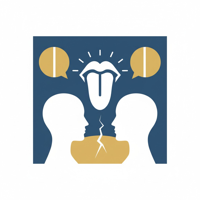

------------------------------------------------------------------
Inference: A sharp tongue
Path: img\Idiom\Minimalist\spill_the_beans(Minimalist-Style).jpg
Item: spill the beans


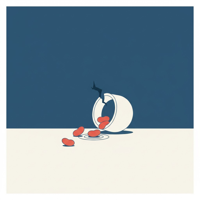

------------------------------------------------------------------
Inference: Spill the beans
Path: img\Idiom\Minimalist\split_hairs(Minimalist-Style).jpg
Item: split hairs


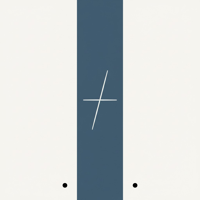

------------------------------------------------------------------
Inference: Cross your t's and dot your i's
Path: img\Idiom\Minimalist\spoon-feed(Minimalist-Style).jpg
Item: spoon-feed


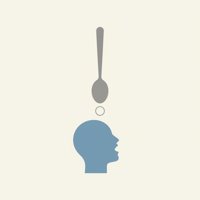

------------------------------------------------------------------
Inference: Spoon-fed
Path: img\Idiom\Minimalist\spring_chicken(Minimalist-Style).jpg
Item: spring chicken


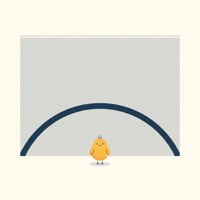

------------------------------------------------------------------
Inference: Water under the bridge
Path: img\Idiom\Minimalist\stab_in_the_back(Minimalist-Style).jpg
Item: stab in the back


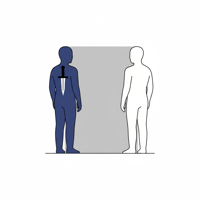

------------------------------------------------------------------
Inference: Backstabber (or Stabbed in the back)
Path: img\Idiom\Minimalist\steal_someone's_thunder(Minimalist-Style).jpg
Item: steal someone's thunder


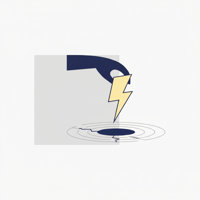

------------------------------------------------------------------
Inference: Lightning in a bottle
Path: img\Idiom\Minimalist\stick_one's_neck_out(Minimalist-Style).jpg
Item: stick one's neck out


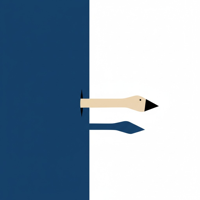

------------------------------------------------------------------
Inference: Stick your neck out
Path: img\Idiom\Minimalist\storm_in_a_teacup(Minimalist-Style).jpg
Item: storm in a teacup


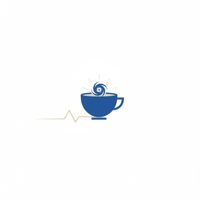

------------------------------------------------------------------
Inference: A storm in a teacup
Path: img\Idiom\Minimalist\straight_from_the_horse's_mouth(Minimalist-Style).jpg
Item: straight from the horse's mouth


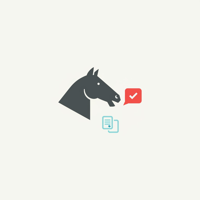

------------------------------------------------------------------
Inference: Straight from the horse's mouth
Path: img\Idiom\Minimalist\strike_while_the_iron_is_hot(Minimalist-Style).jpg
Item: strike while the iron is hot


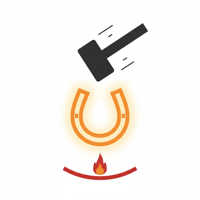

------------------------------------------------------------------
Inference: Strike while the iron is hot
Path: img\Idiom\Minimalist\swallow_a_camel(Minimalist-Style).jpg
Item: swallow a camel


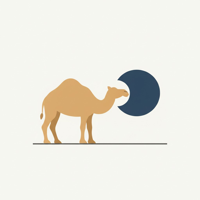

------------------------------------------------------------------
Inference: Camel's nose under the tent
Path: img\Idiom\Minimalist\swan_song(Minimalist-Style).jpg
Item: swan song


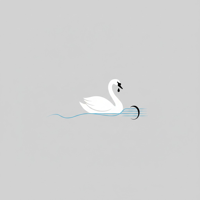

------------------------------------------------------------------
Inference: Swan song
Path: img\Idiom\Minimalist\swept_off_one's_feet(Minimalist-Style).jpg
Item: swept off one's feet


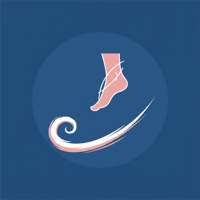

------------------------------------------------------------------
Inference: Walking on air
Path: img\Idiom\Minimalist\swim_with_sharks(Minimalist-Style).jpg
Item: swim with sharks


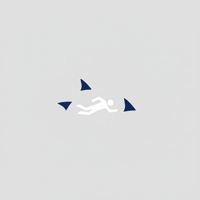

------------------------------------------------------------------
Inference: Swimming with sharks
Path: img\Idiom\Minimalist\take_the_bull_by_the_horns(Minimalist-Style).jpg
Item: take the bull by the horns


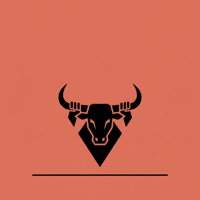

------------------------------------------------------------------
Inference: Take the bull by the horns
Path: img\Idiom\Minimalist\take_with_a_grain_of_salt(Minimalist-Style).jpg
Item: take with a grain of salt


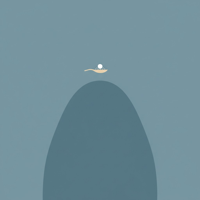

------------------------------------------------------------------
Inference: Make a mountain out of a molehill
Path: img\Idiom\Minimalist\teacher's_pet(Minimalist-Style).jpg
Item: teacher's pet


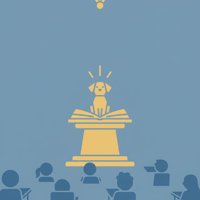

------------------------------------------------------------------
Inference: Dogma
Path: img\Idiom\Minimalist\that's_the_way_the_cookie_crumbles(Minimalist-Style).jpg
Item: that's the way the cookie crumbles


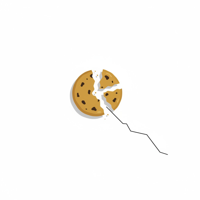

------------------------------------------------------------------
Inference: That's the way the cookie crumbles
Path: img\Idiom\Minimalist\the_writing_on_the_wall(Minimalist-Style).jpg
Item: the writing on the wall


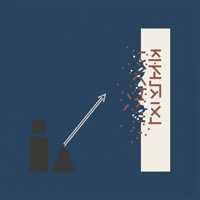

------------------------------------------------------------------
Inference: Break the ice
Path: img\Idiom\Minimalist\thirst_for_knowledge(Minimalist-Style).jpg
Item: thirst for knowledge


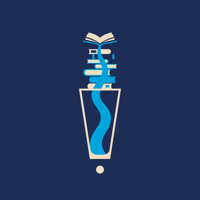

------------------------------------------------------------------
Inference: Thirst for knowledge
Path: img\Idiom\Minimalist\throw_in_the_towel(Minimalist-Style).jpg
Item: throw in the towel


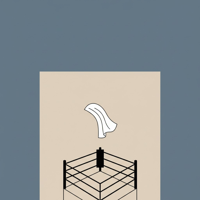

------------------------------------------------------------------
Inference: Throw in the towel
Path: img\Idiom\Minimalist\throw_the_baby_out_with_the_bathwater(Minimalist-Style).jpg
Item: throw the baby out with the bathwater


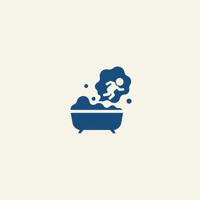

------------------------------------------------------------------
Inference: Throw the baby out with the bathwater
Path: img\Idiom\Minimalist\tighten_one's_belt(Minimalist-Style).jpg
Item: tighten one's belt


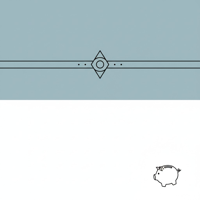

------------------------------------------------------------------
Inference: Tighten one's belt
Path: img\Idiom\Minimalist\time_flies(Minimalist-Style).jpg
Item: time flies


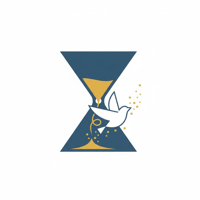

------------------------------------------------------------------
Inference: Time flies
Path: img\Idiom\Minimalist\tip_of_the_iceberg(Minimalist-Style).jpg
Item: tip of the iceberg


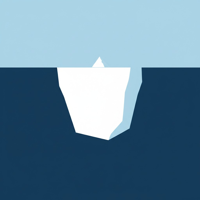

------------------------------------------------------------------
Inference: The tip of the iceberg
Path: img\Idiom\Minimalist\top_banana(Minimalist-Style).jpg
Item: top banana


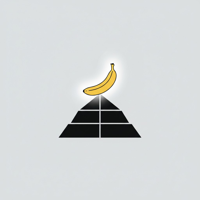

------------------------------------------------------------------
Inference: Top banana
Path: img\Idiom\Minimalist\top_dog(Minimalist-Style).jpg
Item: top dog


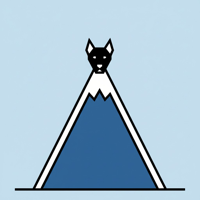

------------------------------------------------------------------
Inference: Top cat
Path: img\Idiom\Minimalist\tough_cookie(Minimalist-Style).jpg
Item: tough cookie


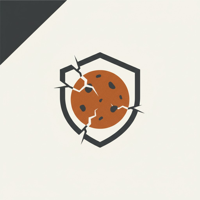

------------------------------------------------------------------
Inference: That's the way the cookie crumbles
Path: img\Idiom\Minimalist\two_peas_in_a_pod(Minimalist-Style).jpg
Item: two peas in a pod


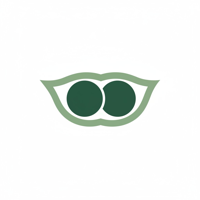

------------------------------------------------------------------
Inference: Two peas in a pod
Path: img\Idiom\Minimalist\under_the_microscope(Minimalist-Style).jpg
Item: under the microscope


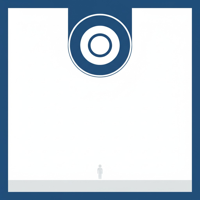

------------------------------------------------------------------
Inference: Aim high
Path: img\Idiom\Minimalist\under_the_weather(Minimalist-Style).jpg
Item: under the weather


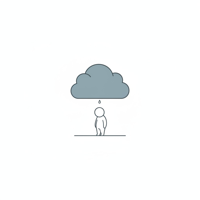

------------------------------------------------------------------
Inference: Under a cloud
Path: img\Idiom\Minimalist\walk_on_eggshells(Minimalist-Style).jpg
Item: walk on eggshells


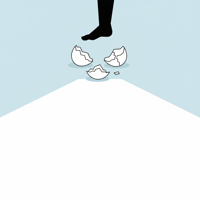

------------------------------------------------------------------
Inference: Walking on eggshells
Path: img\Idiom\Minimalist\walk_the_tightrope(Minimalist-Style).jpg
Item: walk the tightrope


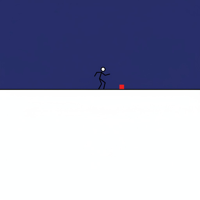

------------------------------------------------------------------
Inference: Writer's block
Path: img\Idiom\Minimalist\water_under_the_bridge(Minimalist-Style).jpg
Item: water under the bridge


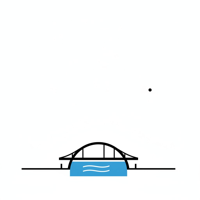

------------------------------------------------------------------
Inference: Water under the bridge
Path: img\Idiom\Minimalist\wear_one's_heart_on_one's_sleeve(Minimalist-Style).jpg
Item: wear one's heart on one's sleeve


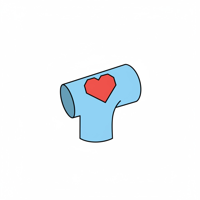

------------------------------------------------------------------
Inference: Wear your heart on your sleeve
Path: img\Idiom\Minimalist\wet_behind_the_ears(Minimalist-Style).jpg
Item: wet behind the ears


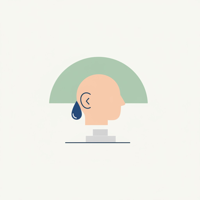

------------------------------------------------------------------
Inference: Headlamp
Path: img\Idiom\Minimalist\when_hell_freezes_over(Minimalist-Style).jpg
Item: when hell freezes over


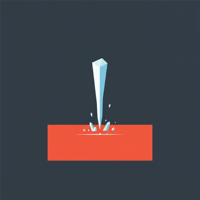

------------------------------------------------------------------
Inference: Break the ice
Path: img\Idiom\Minimalist\when_pigs_fly(Minimalist-Style).jpg
Item: when pigs fly


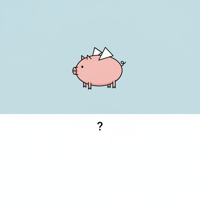

------------------------------------------------------------------
Inference: When pigs fly
Path: img\Idiom\Minimalist\window_shopping(Minimalist-Style).jpg
Item: window shopping


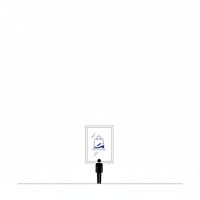

------------------------------------------------------------------
Inference: Window shopping
Path: img\Idiom\Minimalist\wires_crossed(Minimalist-Style).jpg
Item: wires crossed


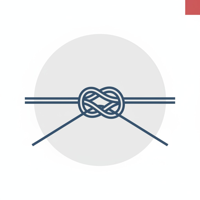

------------------------------------------------------------------
Inference: Tie the knot
Path: img\Idiom\Minimalist\wolf_in_sheep's_clothing(Minimalist-Style).jpg
Item: wolf in sheep's clothing


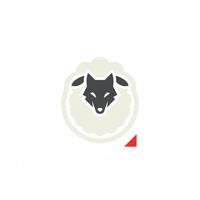

------------------------------------------------------------------
Inference: Wolf in sheep's clothing
Path: img\Idiom\Minimalist\work_like_a_dog(Minimalist-Style).jpg
Item: work like a dog


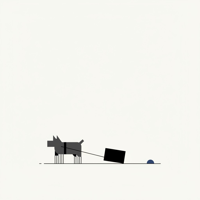

------------------------------------------------------------------
Inference: Working for peanuts
Path: img\Idiom\Minimalist\yellow-bellied(Minimalist-Style).jpg
Item: yellow-bellied


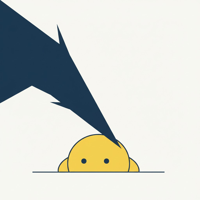

------------------------------------------------------------------
Inference: Point the finger
Path: img\Idiom\Minimalist\zip_one's_lip(Minimalist-Style).jpg
Item: zip one's lip


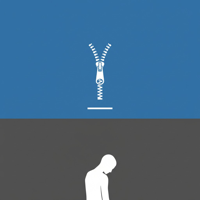

------------------------------------------------------------------
Inference: Open up


In [50]:
from pathlib import Path
from PIL import Image
from IPython.display import display

# 1. Define the directory (Relative path)
target_dir = Path(r"img\Idiom\Minimalist")

# 2. Define valid image extensions
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
prompt = promptMLLM["idioms"]
Recognition_List=[]
# 3. Iterate, process, and display
for file_path in target_dir.iterdir():
    if file_path.suffix.lower() in valid_extensions:
        raw_name = file_path.stem
        clean_name = raw_name.split('(')[0].replace('_', ' ').strip()
        print(f"Path: {file_path}")
        print(f"Item: {clean_name}")
        try:
            # Open the image
            with Image.open(file_path) as img:
                # Resize to exactly 200x200 pixels
                img_resized = img.resize((200, 200))
                
                # Display inline
                display(img_resized)
                
        except Exception as e:
            print(f"Error reading image: {e}")
        response = infer(file_path, prompt)
        print('-'*66)
        print("Inference:",response)   
        Recognition_List.append((clean_name,response))
        print('='*99)

In [49]:
print(len(Recognition_List))
# print(Recognition_List)

234
